In [1]:
"""
Import
"""
from matplotlib.colors import ListedColormap, BoundaryNorm, TwoSlopeNorm, LinearSegmentedColormap, LogNorm
import matplotlib.cm as cm
import matplotlib.lines as mlines
from typing import List,Dict

import numpy as np
import pandas as pd
import xarray as xr

import pickle
import os
import glob
import sys
from datetime import datetime, timedelta
import matplotlib.patches as patches
from matplotlib.path import Path
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs  # Import cartopy ccrs
import cartopy.feature as cfeature  # Import cartopy common features
from matplotlib import animation
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
import scipy.stats
import math
import time as time_mod

sys.path.insert(0, "/home/chalifour/code/master")
from fct_script.func_py import get_proj_extent
import fct_script.rpn_funcs_chris as rpn_chris
from fct_script.get_domain import get_domain_info
from fct_script.func_py import get_colormap_precip, categorical_cmap
from matplotlib.patches import Patch
from Annual_analysis.fct_diff_map import get_cmap,biais,get_data_stat,get_data_stat_nosummean
import xesmf as xe
import seaborn as sns
from metpy.plots import ctables
# from func_py import get_proj_extent


try:
    import rpnpy.librmn.all as rmn  # Module to read RPN files
    from rotated_lat_lon import RotatedLatLon  # Module to project field on native grid (created by Sasha Huziy)
except ImportError as err:
    print(f"RPNPY can only be use on the server. It can't be use on a personal computer."
          f"\nError throw :{err}")

In [2]:

begin_1, end_1 = '2020-10', '2021-04'
begin_2, end_2 = '2021-10', '2022-04'
begin_t, end_t = '2020-10', '2022-04'
begin_date, end_date = datetime.strptime(begin_1, '%Y-%m'), datetime.strptime(end_1, '%Y-%m')

timerange_month = pd.date_range(begin_1, end_1, freq='MS')

timerange_day = pd.date_range(begin_1, end_1, freq='D')

season = ['ON', 'DJF', 'MAM']
season_dict = {'ON': {'month': [10, 11], 'year': begin_date.year},
               'DJF': {'month': [12, 1, 2], 'year': begin_date.year},
               'MAM': {'month': [3, 4, 5], 'year': end_date.year}}

In [3]:
lonlat_path = '/upslope/chalifour/code_fig_bassin_domaine/Disdrometres_coordonnées.csv'
df_disdro = pd.read_csv(lonlat_path, header=0)
df_disdro.set_index('Name', inplace=True)
data_path = sorted(glob.glob(fr"/upslope/chalifour/projet_maitrise/"))[0]
HQ_compiled_savepath = os.path.join(data_path, r"data_format-master/Data.nosync/station_gmon/Full_datasets")
file_1h = glob.glob(HQ_compiled_savepath + '/dataset_1h.csv')

path_save_df = '/upslope/chalifour/projet_maitrise/dataframe_obs_formated'

In [4]:
def get_verts_new(categ_box):
    verts = [(categ_box['west'], categ_box['south']),
             (categ_box['west'], categ_box['north']),
             (categ_box['east'], categ_box['north']),
             (categ_box['east'], categ_box['south']),
             (0., 0.)]
    return verts


In [5]:
m, lonE2p5, latE2p5 = get_proj_extent()

{}
263.0 47.5 353.0 0.0


In [6]:
dict_label_color = {'LIQUID': 'Liquid accumulation in\nwater equivalent [mm]',
                    'FR': 'Freezing rain accumulation in\nwater equivalent [mm]',
                    'MIXFR': 'Mix + Fr accumulation in\nwater equivalent [mm]',
                    'MIX': 'Mix accumulation in\nwater equivalent [mm]',
                    'SOLID': 'Solid accumulation in\nwater equivalent [mm]',
                    'TT': "Mean 2 m temperature [\u2103]",
                    'PR':"Total accumulation in\nwater equivalent [mm]"}
dict_unit = {'LIQUID': '[mm]',
                    'FR': '[mm]',
                    'MIXFR': '[mm]',
                    'MIX': '[mm]',
                    'SOLID': '[mm]',
                    'TT': "[\u2103]",
                    'PR':"[mm]"}

# Obs


In [7]:
dataframe_1h_obs = pd.read_csv(path_save_df + f'/dataframe_1h_stat_formated_2year.csv',
                               parse_dates=['date'])
list_subdf = []
for stat,subdf in dataframe_1h_obs.groupby('filename'):

    subdf.set_index('date', inplace=True)
    subdf.index.name = None
    subdf.sort_index(inplace=True)
    subdf = subdf.loc[begin_t: end_t]
    list_subdf.append(subdf)

dataframe_1h_obs = pd.concat(list_subdf)


dict_obs = {'frac_liquid': 'frac_liquide'}
dataframe_1h_uqam = pd.read_csv(path_save_df + f'/dataframe_uqam_formated_2year.csv',
                                parse_dates=['date'])
dataframe_1h_uqam.set_index('date', inplace=True)
dataframe_1h_uqam.rename(columns=dict_obs,
                         inplace=True)
dataframe_1h_uqam = dataframe_1h_uqam.loc[begin_t: end_t]




dataframe_1h_momo = pd.read_csv(path_save_df + f'/dataframe_momo_formated_2year.csv',
                                parse_dates=['date'])
dataframe_1h_momo.set_index('date', inplace=True)
dataframe_1h_momo.rename(columns=dict_obs,
                         inplace=True)
dataframe_1h_momo = dataframe_1h_momo.loc[begin_t: end_t]







# Simulation

In [8]:
list_phase = ['LIQUID', 'FR', 'MIXFR', 'MIX', 'SOLID', 'PR']
dict_era5 = {}
# ERA5
path_saving = '/upslope/chalifour/projet_maitrise/data_simulation_monthly'

paths_era5_1 = glob.glob(
    f'/upslope/chalifour/projet_maitrise/data_simulation_monthly/ERA5-land/PR_2020_1[0-2]_array.nc') + glob.glob(
    f'/upslope/chalifour/projet_maitrise/data_simulation_monthly/ERA5-land/PR_2021_[1-6]_array.nc')
# paths_era5 = glob.glob(
#     f'/upslope/chalifour/projet_maitrise/data_simulation_monthly/ERA5-land/UU_2020_10_array.nc')

paths_era5_2 = glob.glob(
    f'/upslope/chalifour/projet_maitrise/data_simulation_monthly/ERA5-land/PR_2021_1[0-2]_array.nc') + glob.glob(
    f'/upslope/chalifour/projet_maitrise/data_simulation_monthly/ERA5-land/PR_2022_[1-6]_array.nc')

list_era5 = []

paths_era5 = paths_era5_1+paths_era5_2
for path in paths_era5:
    data_era5 = xr.open_mfdataset(path,combine='by_coords', concat_dim="time")
    name = list(data_era5.keys())
    dict_name = {name[0]: 'PR'}
    data_era5 = data_era5.rename(dict_name)

    list_era5.append(data_era5)


pr_era5 = xr.concat(list_era5, dim='time')
# xrdata_fr_on = xr.open_mfdataset(path_saving + f"/ERA5/fr_ON_{begin_date.year}.nc")
# xrdata_fr_djf = xr.open_mfdataset(path_saving + f"/ERA5/fr_DJF_{begin_date.year}.nc")
# xrdata_fr_mam = xr.open_mfdataset(path_saving + f"/ERA5/fr_MAM_{begin_date.year}.nc")
# dict_era5['FR'] = {'SON': xrdata_fr_on, 'DJF': xrdata_fr_djf, 'MAM': xrdata_fr_mam}
#
# xrdata_mix_on = xr.open_mfdataset(path_saving + f"/ERA5/mix_ON_{begin_date.year}.nc")
# xrdata_mix_djf = xr.open_mfdataset(path_saving + f"/ERA5/mix_DJF_{begin_date.year}.nc")
# xrdata_mix_mam = xr.open_mfdataset(path_saving + f"/ERA5/mix_MAM_{begin_date.year}.nc")
# dict_era5['MIX'] = {'SON': xrdata_mix_on, 'DJF': xrdata_mix_djf, 'MAM': xrdata_mix_mam}
#
# xrdata_solid_on = xr.open_mfdataset(path_saving + f"/ERA5/solid_ON_{begin_date.year}.nc")
# xrdata_solid_djf = xr.open_mfdataset(path_saving + f"/ERA5/solid_DJF_{begin_date.year}.nc")
# xrdata_solid_mam = xr.open_mfdataset(path_saving + f"/ERA5/solid_MAM_{begin_date.year}.nc")
# dict_era5['SOLID'] = {'SON': xrdata_solid_on, 'DJF': xrdata_solid_djf, 'MAM': xrdata_solid_mam}
#
# xrdata_liquid_on = xr.open_mfdataset(path_saving + f"/ERA5/liquid_ON_{begin_date.year}.nc")
# xrdata_liquid_djf = xr.open_mfdataset(path_saving + f"/ERA5/liquid_DJF_{begin_date.year}.nc")
# xrdata_liquid_mam = xr.open_mfdataset(path_saving + f"/ERA5/liquid_MAM_{begin_date.year}.nc")
# dict_era5['LIQUID'] = {'SON': xrdata_liquid_on, 'DJF': xrdata_liquid_djf, 'MAM': xrdata_liquid_mam}
#
# xrdata_mixfr_on = xr.open_mfdataset(path_saving + f"/ERA5/mixfr_ON_{begin_date.year}.nc")
# xrdata_mixfr_djf = xr.open_mfdataset(path_saving + f"/ERA5/mixfr_DJF_{begin_date.year}.nc")
# xrdata_mixfr_mam = xr.open_mfdataset(path_saving + f"/ERA5/mixfr_MAM_{begin_date.year}.nc")
# dict_era5['MIXFR'] = {'SON': xrdata_mixfr_on, 'DJF': xrdata_mixfr_djf, 'MAM': xrdata_mixfr_mam}

# xrdata_pr_on = xr.open_mfdataset(path_saving + f"/ERA5/pr_ON_{begin_date.year}.nc")
# name = list(xrdata_pr_on.keys())
# dict_name = {name[0]: 'PR'}
# xrdata_pr_on = xrdata_pr_on.rename(dict_name)

# xrdata_pr_djf = xr.open_mfdataset(path_saving + f"/ERA5/pr_DJF_{begin_date.year}.nc")
# name = list(xrdata_pr_djf.keys())
# dict_name = {name[0]: 'PR'}
# xrdata_pr_djf = xrdata_pr_djf.rename(dict_name)

# xrdata_pr_mam = xr.open_mfdataset(path_saving + f"/ERA5/pr_MAM_{begin_date.year}.nc")
# name = list(xrdata_pr_mam.keys())
# dict_name = {name[0]: 'PR'}
# xrdata_pr_mam = xrdata_pr_mam.rename(dict_name)
# dict_era5['PR'] = {'SON': xrdata_pr_on, 'DJF': xrdata_pr_djf, 'MAM': xrdata_pr_mam}

# 11km
dict_11km = {}
for phase in list_phase:
    with open(path_saving + f"/11km/{phase}_season_dict_{begin_date.year}.pickle", 'rb') as f:
        dict_season_11km = pickle.load(f, encoding='unicode_escape')
        dict_11km[phase] = dict_season_11km
        f.close()

dict_11km_p3 = {}
for phase in list_phase:
    with open(path_saving + f"/11km_P3/{phase}_season_dict_2020.pickle", 'rb') as f:
        dict_season_11km_1 = pickle.load(f, encoding='unicode_escape')
        f.close()
    with open(path_saving + f"/11km_P3/{phase}_season_dict_2021.pickle", 'rb') as f:
        dict_season_11km_2 = pickle.load(f, encoding='unicode_escape')
        f.close()

    dict_season_tot = {}
    for key in dict_season_11km_2.keys():
        dict_season_tot[key] = xr.concat([dict_season_11km_1[key],dict_season_11km_2[key]],dim='time').sum(dim='time')

    dict_11km_p3[phase] = dict_season_tot
# 2p5km
dict_2p5km = {}
for phase in list_phase:
    with open(path_saving + f"/2p5km/{phase}_season_dict_{begin_date.year}.pickle", 'rb') as f:
        dict_season_2p5km = pickle.load(f, encoding='unicode_escape')
        dict_2p5km[phase] = dict_season_2p5km
        f.close()

dict_2p5km_p3 = {}
for phase in list_phase:
    with open(path_saving + f"/2p5km_P3/{phase}_season_dict_2020.pickle", 'rb') as f:
        dict_season_2p5km_1 = pickle.load(f, encoding='unicode_escape')

        f.close()
    with open(path_saving + f"/2p5km_P3/{phase}_season_dict_2021.pickle", 'rb') as f:
        dict_season_2p5km_2 = pickle.load(f, encoding='unicode_escape')

        f.close()
    dict_season_tot = {}
    for key in dict_season_2p5km_2.keys():
        dict_season_tot[key] = xr.concat([dict_season_2p5km_1[key],dict_season_2p5km_2[key]],dim='time').sum(dim='time')

    dict_2p5km_p3[phase] = dict_season_tot


dict_daymet = {}
list_phase_d = ['tavg', 'prcp']
for phase in list_phase_d:

    daymet_data_1 = xr.open_mfdataset(glob.glob('/upslope/chalifour/projet_maitrise/data_simulation_monthly' + f"/daymet/{phase}_20201[0-2].nc") + glob.glob('/upslope/chalifour/projet_maitrise/data_simulation_monthly' + f"/daymet/{phase}_20210[1-4].nc"))

    daymet_data_2 = xr.open_mfdataset(glob.glob('/upslope/chalifour/projet_maitrise/data_simulation_monthly' + f"/daymet/{phase}_20211[0-2].nc") + glob.glob('/upslope/chalifour/projet_maitrise/data_simulation_monthly' + f"/daymet/{phase}_20220[1-4].nc"))
    dict_daymet[phase] = xr.concat([daymet_data_1,daymet_data_2],dim='time')


paths_capa_1 = glob.glob(
    f'/upslope/chalifour/projet_maitrise/data_simulation_monthly/CaPA/PR_2020_9.pickle') + glob.glob(
    f'/upslope/chalifour/projet_maitrise/data_simulation_monthly/CaPA/PR_2020_1*[0-2].pickle') + glob.glob(
    f'/upslope/chalifour/projet_maitrise/data_simulation_monthly/CaPA/PR_2021_*[1-6].pickle')
paths_capa_1 = paths_capa_1[0:-2]
paths_capa_2 = glob.glob(
    f'/upslope/chalifour/projet_maitrise/data_simulation_monthly/CaPA/PR_2021_9.pickle') + glob.glob(
    f'/upslope/chalifour/projet_maitrise/data_simulation_monthly/CaPA/PR_2021_1*[0-2].pickle') + glob.glob(
    f'/upslope/chalifour/projet_maitrise/data_simulation_monthly/CaPA/PR_2022_*[1-6].pickle')


paths_capa = paths_capa_1+paths_capa_2

list_capa = []
for path in paths_capa:
    with open(path, 'rb') as f:
        data_capa = pickle.load(f, encoding='unicode_escape')
        f.close()

        grid_lonlat = m.transform_points(ccrs.PlateCarree(), data_capa.lon.values, data_capa.lat.values)[:, :, 0:2]

        xll, yll = m.transform_point(lonE2p5[0, 0], latE2p5[0, 0], ccrs.PlateCarree())
        xur, yur = m.transform_point(lonE2p5[-1, -1], latE2p5[-1, -1], ccrs.PlateCarree())

        box = {'west': xll + 17, 'east': xur - 9, 'north': yur - 1, 'south': yll + 4}

        vert = get_verts_new(box)
        codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY, ]
        path_small = Path(vert, codes)

        shape_grid = np.shape(grid_lonlat)
        point_in_domain = path_small.contains_points(grid_lonlat.reshape(shape_grid[0] * shape_grid[1], 2),
                                                     radius=0).reshape(shape_grid[0], shape_grid[1])

        mask_capa = point_in_domain

        data_capa_mask = data_capa.where(mask_capa)
        data_capa_mask = data_capa_mask.dropna(dim='y', how="all")
        data_capa_mask = data_capa_mask.dropna(dim='x', how="all")
        list_capa.append(data_capa_mask)

data_capa = xr.concat(list_capa, dim='time')
# print(data_capa.index.duplicated())
_, index = np.unique(data_capa['time'], return_index=True)
data_capa = data_capa.isel(time=index)
# data_capa = data_capa.drop_duplicates(dim='time')
data_capa_1 = data_capa.loc['2020-10':'2021-04']
data_capa_1 = data_capa_1.resample(time='1D').sum()
data_capa_2 = data_capa.loc['2021-10':'2022-04']
data_capa_2 = data_capa_2.resample(time='1D').sum()


data_capa = xr.concat([data_capa_1,data_capa_2],dim='time')

list_capa = []

In [9]:
# liq_era5 = dict_era5['LIQUID']['SON'] + dict_era5['LIQUID']['DJF'] + dict_era5['LIQUID']['MAM']
# pr_era5 = dict_era5['PR']['SON'] + dict_era5['PR']['DJF'] + dict_era5['PR']['MAM']
#
# fr_era5 = dict_era5['FR']['SON'] + dict_era5['FR']['DJF'] + dict_era5['FR']['MAM']
# mixfr_era5 = dict_era5['MIXFR']['SON'] + dict_era5['MIXFR']['DJF'] + dict_era5['MIXFR']['MAM']
# mix_era5 = dict_era5['MIX']['SON'] + dict_era5['MIX']['DJF'] + dict_era5['MIX']['MAM']
# solid_era5 = dict_era5['SOLID']['SON'] + dict_era5['SOLID']['DJF'] + dict_era5['SOLID']['MAM']
# sum_era5 = liq_era5 + fr_era5 + mixfr_era5 + mix_era5 + solid_era5
# lon, lat = np.meshgrid(liq_era5.longitude.values, liq_era5.latitude.values)

# dict_era5 = []
# liq_11km = dict_11km['LIQUID']['SON'] + dict_11km['LIQUID']['DJF'] + dict_11km['LIQUID']['MAM']
# pr_11km = dict_11km['PR']['SON'] + dict_11km['PR']['DJF'] + dict_11km['PR']['MAM']
# fr_11km = dict_11km['FR']['SON'] + dict_11km['FR']['DJF'] + dict_11km['FR']['MAM']
# mixfr_11km = dict_11km['MIXFR']['SON'] + dict_11km['MIXFR']['DJF'] + dict_11km['MIXFR']['MAM']
# mix_11km = dict_11km['MIX']['SON'] + dict_11km['MIX']['DJF'] + dict_11km['MIX']['MAM']
# solid_11km = dict_11km['SOLID']['SON'] + dict_11km['SOLID']['DJF'] + dict_11km['SOLID']['MAM']
# dict_11km = []
# sum_11km = liq_11km + fr_11km + mixfr_11km + mix_11km + solid_11km
#
# liq_11km_p3 = dict_11km_p3['LIQUID']['SON'] + dict_11km_p3['LIQUID']['DJF'] + dict_11km_p3['LIQUID']['MAM']
# pr_11km_p3 = dict_11km_p3['PR']['SON'] + dict_11km_p3['PR']['DJF'] + dict_11km_p3['PR']['MAM']
# fr_11km_p3 = dict_11km_p3['FR']['SON'] + dict_11km_p3['FR']['DJF'] + dict_11km_p3['FR']['MAM']
# mixfr_11km_p3 = dict_11km_p3['MIXFR']['SON'] + dict_11km_p3['MIXFR']['DJF'] + dict_11km_p3['MIXFR']['MAM']
# mix_11km_p3 = dict_11km_p3['MIX']['SON'] + dict_11km_p3['MIX']['DJF'] + dict_11km_p3['MIX']['MAM']
# solid_11km_p3 = dict_11km_p3['SOLID']['SON'] + dict_11km_p3['SOLID']['DJF'] + dict_11km_p3['SOLID']['MAM']
# dict_11km_p3 = []
# sum_11km_p3 = liq_11km_p3 + fr_11km_p3 + mixfr_11km_p3 + mix_11km + solid_11km_p3
#
# liq_2p5km = dict_2p5km['LIQUID']['SON'] + dict_2p5km['LIQUID']['DJF'] + dict_2p5km['LIQUID']['MAM']
# pr_2p5km = dict_2p5km['PR']['SON'] + dict_2p5km['PR']['DJF'] + dict_2p5km['PR']['MAM']
# fr_2p5km = dict_2p5km['FR']['SON'] + dict_2p5km['FR']['DJF'] + dict_2p5km['FR']['MAM']
# mixfr_2p5km = dict_2p5km['MIXFR']['SON'] + dict_2p5km['MIXFR']['DJF'] + dict_2p5km['MIXFR']['MAM']
# mix_2p5km = dict_2p5km['MIX']['SON'] + dict_2p5km['MIX']['DJF'] + dict_2p5km['MIX']['MAM']
# solid_2p5km = dict_2p5km['SOLID']['SON'] + dict_2p5km['SOLID']['DJF'] + dict_2p5km['SOLID']['MAM']
# dict_2p5km = []
#
# sum_2p5km = liq_2p5km + fr_2p5km + mixfr_2p5km + mix_2p5km + solid_2p5km
#
# liq_2p5km_p3 = dict_2p5km_p3['LIQUID']['SON'] + dict_2p5km_p3['LIQUID']['DJF'] + dict_2p5km_p3['LIQUID']['MAM']
# pr_2p5km_p3 = dict_2p5km_p3['PR']['SON'] + dict_2p5km_p3['PR']['DJF'] + dict_2p5km_p3['PR']['MAM']
# fr_2p5km_p3 = dict_2p5km_p3['FR']['SON'] + dict_2p5km_p3['FR']['DJF'] + dict_2p5km_p3['FR']['MAM']
# mixfr_2p5km_p3 = dict_2p5km_p3['MIXFR']['SON'] + dict_2p5km_p3['MIXFR']['DJF'] + dict_2p5km_p3['MIXFR']['MAM']
# mix_2p5km_p3 = dict_2p5km_p3['MIX']['SON'] + dict_2p5km_p3['MIX']['DJF'] + dict_2p5km_p3['MIX']['MAM']
# solid_2p5km_p3 = dict_2p5km_p3['SOLID']['SON'] + dict_2p5km_p3['SOLID']['DJF'] + dict_2p5km_p3['SOLID']['MAM']
# dict_2p5km_p3 = []
#
# sum_2p5km_p3 = liq_2p5km_p3 + fr_2p5km_p3 + mixfr_2p5km_p3 + mix_2p5km_p3 + solid_2p5km_p3

In [10]:
make_data = False
# make_data = True
if make_data:

    # # temp

    if begin_1 == '2020-10':
        paths_era5 = glob.glob(
            f'/upslope/chalifour/projet_maitrise/data_simulation_monthly/ERA5-land/PR_2020_1[0-2]_array.nc') + glob.glob(
            f'/upslope/chalifour/projet_maitrise/data_simulation_monthly/ERA5-land/PR_2021_[1-6]_array.nc')
        # paths_era5 = glob.glob(
        #     f'/upslope/chalifour/projet_maitrise/data_simulation_monthly/ERA5-land/UU_2020_10_array.nc')
    else:
        paths_era5 = glob.glob(
            f'/upslope/chalifour/projet_maitrise/data_simulation_monthly/ERA5-land/PR_2021_1[0-2]_array.nc') + glob.glob(
            f'/upslope/chalifour/projet_maitrise/data_simulation_monthly/ERA5-land/PR_2022_[1-6]_array.nc')

    list_era5 = []

    for path in paths_era5:
        data_era5 = xr.open_mfdataset(path,combine='by_coords', concat_dim="time")
        name = list(data_era5.keys())
        dict_name = {name[0]: 'PR'}
        data_era5 = data_era5.rename(dict_name)
        list_era5.append(data_era5)


    tt_era5 = xr.concat(list_era5, dim='time')

    mean_daily =tt_era5.resample(time='1D').sum()

    tt_era5_mean = mean_daily.mean(dim='time')
    #
    mean_daily.to_netcdf(path_saving+f"/data_mask/PR_era5_mask_{begin_date.year}_{end_date.year}.nc")
    list_temp_era5 = []

    # xrdata_temp_on = xr.open_mfdataset(path_saving + f"/ERA5/tt_ON_{begin_date.year}_array.nc")
    # name = list(xrdata_temp_on.keys())
    # dict_name = {name[0]: 'TT'}
    # xrdata_temp_on = xrdata_temp_on.rename(dict_name)
    # xrdata_temp_djf = xr.open_mfdataset(path_saving + f"/ERA5/tt_DJF_{begin_date.year}_array.nc")
    # name = list(xrdata_temp_djf.keys())
    # dict_name = {name[0]: 'TT'}
    # xrdata_temp_djf = xrdata_temp_djf.rename(dict_name)
    # xrdata_temp_mam = xr.open_mfdataset(path_saving + f"/ERA5/tt_MAM_{begin_date.year}_array.nc")
    # name = list(xrdata_temp_mam.keys())
    # dict_name = {name[0]: 'TT'}
    # xrdata_temp_mam = xrdata_temp_mam.rename(dict_name)
    #
    # xrdata_temp = xr.concat([xrdata_temp_on, xrdata_temp_djf, xrdata_temp_mam], dim='time')
    # xrdata_temp = xrdata_temp.mean(dim='time')
    # xrdata_temp_on = []
    # xrdata_temp_djf = []
    # xrdata_temp_mam = []
    #
    # lon_era5, lat_era5 = np.meshgrid(xrdata_temp.longitude.values, xrdata_temp.latitude.values)
    #
    # grid_lonlat = m.transform_points(ccrs.PlateCarree(), lon_era5, lat_era5)[:, :, 0:2]
    #
    # xll, yll = m.transform_point(lonE2p5[0, 0], latE2p5[0, 0], ccrs.PlateCarree())
    # xur, yur = m.transform_point(lonE2p5[-1, -1], latE2p5[-1, -1], ccrs.PlateCarree())
    #
    # box = {'west': xll + 17, 'east': xur - 9, 'north': yur - 1, 'south': yll + 4}
    #
    # vert = get_verts_new(box)
    # codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY, ]
    # path_small = Path(vert, codes)
    #
    # shape_grid = np.shape(grid_lonlat)
    # point_in_domain = path_small.contains_points(grid_lonlat.reshape(shape_grid[0] * shape_grid[1], 2),
    #                                              radius=0).reshape(shape_grid[0], shape_grid[1])
    #
    # mask_era5 = point_in_domain
    #
    # xrtemp_mask_era5 = xrdata_temp.where(mask_era5)
    # xrtemp_mask_era5 = xrtemp_mask_era5.dropna(dim='latitude',how="all")
    # xrtemp_mask_era5 = xrtemp_mask_era5.dropna(dim='longitude',how="all")
    # xrdata_temp = []
    #
    # fig = plt.figure(facecolor='white', figsize=(15, 10))
    # spec = fig.add_gridspec(ncols=1, nrows=1, )
    # # temp
    # ax0 = fig.add_subplot(spec[0, 0], projection=m)
    #
    # # Set geographic features
    # ax0.add_feature(cfeature.OCEAN.with_scale('50m'), alpha=0.5)  # couche ocean
    # ax0.add_feature(cfeature.LAND.with_scale('50m'), facecolor='none')  # couche land
    # # ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac
    # ax0.add_feature(cfeature.BORDERS.with_scale('50m'))  # couche frontieres
    # # ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche rivières
    # coast = cfeature.NaturalEarthFeature(category='physical', scale='10m', facecolor='none',
    #                                      name='coastline')  # Couche côtières
    # ax0.add_feature(coast, edgecolor='black')
    # ax0.add_feature(cfeature.LAKES)
    # states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
    #                                                 scale='10m', facecolor='none')  # Couche provinces
    # min_temp = -16
    # max_temp = 7
    # lon_temp,lat_temp = np.meshgrid(xrtemp_mask_era5.longitude.values,xrtemp_mask_era5.latitude.values)
    # ax0.add_feature(states_provinces, edgecolor='grey')
    # ax0.set_extent([xll + 17, xur - 9, yll + 4, yur - 1], crs=m)
    # i=1
    # imtemp = ax0.contourf(lon_temp[::i,::i], lat_temp[::i,::i], xrtemp_mask_era5.to_array()[0,::i,::i], 60,
    #                            transform=ccrs.PlateCarree(), cmap='RdBu_r',norm=TwoSlopeNorm(vmax=max_temp, vcenter=0, vmin=min_temp),corner_mask=True)
    # plt.show()
    # plt.close(fig)

    # list_temp_11km = []
    # # :-1
    # for month in timerange_month[:-1]:
    #     with open(path_saving + f"/11km/TT_{month.year}_{month.month}.pickle", 'rb') as f:
    #         array_month_11km = pickle.load(f, encoding='unicode_escape')
    #
    #         grid_lonlat_11km = m.transform_points(ccrs.PlateCarree(), array_month_11km.lon.values - 360,
    #                                               array_month_11km.lat.values)[:, :, 0:2]
    #
    #         shape_grid_11km = np.shape(grid_lonlat_11km)
    #         point_in_domain_11km = path_small.contains_points(
    #             grid_lonlat_11km.reshape(shape_grid_11km[0] * shape_grid_11km[1], 2),
    #             radius=0).reshape(shape_grid_11km[0], shape_grid_11km[1])
    #         mask_11km = point_in_domain_11km
    #
    #         xrtemp_mask_11km = array_month_11km.where(mask_11km).dropna(dim='y', how="all").dropna(dim='x', how="all")
    #
    #         max_11km = xrtemp_mask_11km.resample(time="D").max()
    #         min_11km = xrtemp_mask_11km.resample(time="D").min()
    #         xrtemp_mask_11km = (max_11km + min_11km)/2
    #
    #         list_temp_11km.append(xrtemp_mask_11km)
    #         print(f'{month.year}-{month.month} done!')
    #         array_month_11km = []
    #         xrtemp_mask_11km = []
    #         f.close()
    #
    # temp_mean_11km = xr.concat(list_temp_11km, dim='time').mean(dim='time')
    # list_temp_11km = []

    # 11 km p3
    list_temp_11km_p3 = []
    for month in timerange_month[:-1]:
        print(f'{month.year}-{month.month} running !')
        with open(path_saving + f"/11km_P3/PR_{month.year}_{month.month}.pickle", 'rb') as f:
            array_month_11km_P3 = pickle.load(f, encoding='unicode_escape')

            grid_lonlat_11km_P3 = m.transform_points(ccrs.PlateCarree(), array_month_11km_P3.lon.values - 360,
                                                     array_month_11km_P3.lat.values)[:, :, 0:2]

            shape_grid_11km_P3 = np.shape(grid_lonlat_11km_P3)
            point_in_domain_11km_p3 = path_small.contains_points(
                grid_lonlat_11km_P3.reshape(shape_grid_11km_P3[0] * shape_grid_11km_P3[1], 2),
                radius=0).reshape(shape_grid_11km_P3[0], shape_grid_11km_P3[1])
            mask_11km_p3 = point_in_domain_11km_p3

            xrtemp_mask_11km_p3 = array_month_11km_P3.where(mask_11km_p3).dropna(dim='y', how="all").dropna(dim='x', how="all")
    #
            xrtemp_mask_11km_p3 = xrtemp_mask_11km_p3.resample(time="D").sum()


            list_temp_11km_p3.append(xrtemp_mask_11km_p3)
            print(f'{month.year}-{month.month} done!')
            array_month_11km_P3 = []
            xrtemp_mask_11km_P3 = []
            f.close()
    # #
    temp_mean_11km_p3 = xr.concat(list_temp_11km_p3, dim='time')
    list_temp_11km_p3 = []
    temp_mean_11km_p3.load()
    temp_mean_11km_p3.to_netcdf(path_saving+f"/data_mask/PR_11kmP3_mask_{begin_date.year}_{end_date.year}.nc")
    # temp_mean_11km_p3=temp_mean_11km_p3.mean(dim='time')
    # # 2p5km
    # list_temp_2p5km = []
    # for month in timerange_month[:1]:
    #     with open(path_saving + f"/2p5km/TT_{month.year}_{month.month}.pickle", 'rb') as f:
    #         array_month_2p5km = pickle.load(f, encoding='unicode_escape')
    #
    #         grid_lonlat_2p5km = m.transform_points(ccrs.PlateCarree(), array_month_2p5km.lon.values - 360,
    #                                                array_month_2p5km.lat.values)[:, :, 0:2]
    #
    #         shape_grid_2p5km = np.shape(grid_lonlat_2p5km)
    #         point_in_domain_2p5km = path_small.contains_points(
    #             grid_lonlat_2p5km.reshape(shape_grid_2p5km[0] * shape_grid_2p5km[1], 2),
    #             radius=0).reshape(shape_grid_2p5km[0], shape_grid_2p5km[1])
    #         mask_2p5km = point_in_domain_2p5km
    #         xrtemp_mask_2p5km = array_month_2p5km.where(mask_2p5km).dropna(dim='y', how="all").dropna(dim='x', how="all")
    #
    #         max_2p5km = xrtemp_mask_2p5km.resample(time="D").max()
    #         min_2p5km = xrtemp_mask_2p5km.resample(time="D").min()
    #         xrtemp_mask_2p5km = (max_2p5km + min_2p5km)/2
    #
    #         list_temp_2p5km.append(xrtemp_mask_2p5km)
    #         xrtemp_mask_2p5km = []
    #         array_month_2p5km = []
    #         print(f'{month.year}-{month.month} done!')
    #         f.close()
    #
    # temp_mean_2p5km = xr.concat(list_temp_2p5km, dim='time').mean(dim='time')
    # list_temp_2p5km = []

    # 2p5km
    list_temp_2p5km_P3= []
    for month in timerange_month[:-1]:
        with open(path_saving + f"/2p5km/PR_{month.year}_{month.month}.pickle", 'rb') as f:
            print(f'{month.year}-{month.month} running !')
            array_month_2p5km_p3 = pickle.load(f, encoding='unicode_escape')

            grid_lonlat_2p5km_P3 = m.transform_points(ccrs.PlateCarree(), array_month_2p5km_p3.lon.values - 360,
                                                   array_month_2p5km_p3.lat.values)[:, :, 0:2]

            shape_grid_2p5km_P3 = np.shape(grid_lonlat_2p5km_P3)
            point_in_domain_2p5km_p3 = path_small.contains_points(
                grid_lonlat_2p5km_P3.reshape(shape_grid_2p5km_P3[0] * shape_grid_2p5km_P3[1], 2),
                radius=0).reshape(shape_grid_2p5km_P3[0], shape_grid_2p5km_P3[1])
            mask_2p5km_P3 = point_in_domain_2p5km_p3
            xrtemp_mask_2p5km_p3 = array_month_2p5km_p3.where(mask_2p5km_P3).dropna(dim='y', how="all").dropna(dim='x', how="all")

            xrtemp_mask_2p5km_p3 = xrtemp_mask_2p5km_p3.resample(time="D").sum()

            list_temp_2p5km_P3.append(xrtemp_mask_2p5km_p3)
            xrtemp_mask_2p5km_P3 = []
            array_month_2p5km_P3 = []
            print(f'{month.year}-{month.month} done !')
            f.close()

    temp_mean_2p5km_p3 = xr.concat(list_temp_2p5km_P3, dim='time')

    temp_mean_2p5km_p3.load()
    temp_mean_2p5km_p3.to_netcdf(path_saving+f"/data_mask/PR_2p5kmP3_mask_{begin_date.year}_{end_date.year}.nc")
    temp_mean_2p5km_p3=temp_mean_2p5km_p3.mean(dim='time')



else:
    pr_era5_1 = xr.open_mfdataset(path_saving+f"/data_mask/PR_era5_mask_2020_2021.nc",combine='by_coords', concat_dim="time")
    pr_era5_1 = pr_era5_1.resample(time='1D').sum()

    pr_11km_p3_1 = xr.open_mfdataset(path_saving+f"/data_mask/PR_11kmP3_mask_2020_2021.nc",combine='by_coords', concat_dim="time")

    pr_2p5km_p3_1 = xr.open_mfdataset(path_saving+f"/data_mask/PR_2p5kmP3_mask_2020_2021.nc",combine='by_coords', concat_dim="time")

    pr_era5_1 = pr_era5_1.sel(time=slice(begin_1,end_1))
    pr_11km_p3_1 = pr_11km_p3_1.sel(time=slice(begin_1,end_1))
    pr_2p5km_p3_1 = pr_2p5km_p3_1.sel(time=slice(begin_1,end_1))


    pr_era5_2 = xr.open_mfdataset(path_saving+f"/data_mask/PR_era5_mask_2021_2022.nc",combine='by_coords', concat_dim="time")
    pr_era5_2 = pr_era5_2.resample(time='1D').sum()

    pr_11km_p3_2 = xr.open_mfdataset(path_saving+f"/data_mask/PR_11kmP3_mask_2021_2022.nc",combine='by_coords', concat_dim="time")

    pr_2p5km_p3_2 = xr.open_mfdataset(path_saving+f"/data_mask/PR_2p5kmP3_mask_2021_2022.nc",combine='by_coords', concat_dim="time")

    pr_era5_2 = pr_era5_2.sel(time=slice(begin_2,end_2))
    pr_11km_p3_2 = pr_11km_p3_2.sel(time=slice(begin_2,end_2))
    pr_2p5km_p3_2 = pr_2p5km_p3_2.sel(time=slice(begin_2,end_2))


    pr_era5 = xr.concat([pr_era5_1,pr_era5_2],dim='time')
    pr_11km_p3 = xr.concat([pr_11km_p3_1,pr_11km_p3_2],dim='time')
    pr_2p5km_p3 = xr.concat([pr_2p5km_p3_1,pr_2p5km_p3_2],dim='time')





In [11]:
make_data = False
# make_data = True
if make_data:

    # # temp

    # if begin == '2020-10':
    #     paths_era5 = glob.glob(
    #         f'/upslope/chalifour/projet_maitrise/data_simulation_monthly/ERA5-land/TT_2020_1[0-2]_array.nc') + glob.glob(
    #         f'/upslope/chalifour/projet_maitrise/data_simulation_monthly/ERA5-land/TT_2021_[1-6]_array.nc')
    #     # paths_era5 = glob.glob(
    #     #     f'/upslope/chalifour/projet_maitrise/data_simulation_monthly/ERA5-land/UU_2020_10_array.nc')
    # else:
    #     paths_era5 = glob.glob(
    #         f'/upslope/chalifour/projet_maitrise/data_simulation_monthly/ERA5-land/TT_2021_1[0-2]_array.nc') + glob.glob(
    #         f'/upslope/chalifour/projet_maitrise/data_simulation_monthly/ERA5-land/TT_2022_[1-6]_array.nc')
    #
    # list_era5 = []
    #
    # for path in paths_era5:
    #     data_era5 = xr.open_mfdataset(path,combine='by_coords', concat_dim="time")
    #     name = list(data_era5.keys())
    #     dict_name = {name[0]: 'TT'}
    #     data_era5 = data_era5.rename(dict_name)
    #     list_era5.append(data_era5)
    #
    #
    # tt_era5 = xr.concat(list_era5, dim='time')
    # min_era_5 = tt_era5.resample(time='1D').min()
    # max_era_5 = tt_era5.resample(time='1D').max()
    # mean_daily = (max_era_5+min_era_5)/2
    #
    # tt_era5_mean = mean_daily.mean(dim='time')
    #
    # mean_daily.to_netcdf(path_saving+f"/data_mask/TT_era5_mask_{begin_date.year}_{end_date.year}.nc")
    # list_temp_era5 = []

    # xrdata_temp_on = xr.open_mfdataset(path_saving + f"/ERA5/tt_ON_{begin_date.year}_array.nc")
    # name = list(xrdata_temp_on.keys())
    # dict_name = {name[0]: 'TT'}
    # xrdata_temp_on = xrdata_temp_on.rename(dict_name)
    # xrdata_temp_djf = xr.open_mfdataset(path_saving + f"/ERA5/tt_DJF_{begin_date.year}_array.nc")
    # name = list(xrdata_temp_djf.keys())
    # dict_name = {name[0]: 'TT'}
    # xrdata_temp_djf = xrdata_temp_djf.rename(dict_name)
    # xrdata_temp_mam = xr.open_mfdataset(path_saving + f"/ERA5/tt_MAM_{begin_date.year}_array.nc")
    # name = list(xrdata_temp_mam.keys())
    # dict_name = {name[0]: 'TT'}
    # xrdata_temp_mam = xrdata_temp_mam.rename(dict_name)
    #
    # xrdata_temp = xr.concat([xrdata_temp_on, xrdata_temp_djf, xrdata_temp_mam], dim='time')
    # xrdata_temp = xrdata_temp.mean(dim='time')
    # xrdata_temp_on = []
    # xrdata_temp_djf = []
    # xrdata_temp_mam = []
    #
    # lon_era5, lat_era5 = np.meshgrid(xrdata_temp.longitude.values, xrdata_temp.latitude.values)
    #
    # grid_lonlat = m.transform_points(ccrs.PlateCarree(), lon_era5, lat_era5)[:, :, 0:2]
    #
    # xll, yll = m.transform_point(lonE2p5[0, 0], latE2p5[0, 0], ccrs.PlateCarree())
    # xur, yur = m.transform_point(lonE2p5[-1, -1], latE2p5[-1, -1], ccrs.PlateCarree())
    #
    # box = {'west': xll + 17, 'east': xur - 9, 'north': yur - 1, 'south': yll + 4}
    #
    # vert = get_verts_new(box)
    # codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY, ]
    # path_small = Path(vert, codes)
    #
    # shape_grid = np.shape(grid_lonlat)
    # point_in_domain = path_small.contains_points(grid_lonlat.reshape(shape_grid[0] * shape_grid[1], 2),
    #                                              radius=0).reshape(shape_grid[0], shape_grid[1])
    #
    # mask_era5 = point_in_domain
    #
    # xrtemp_mask_era5 = xrdata_temp.where(mask_era5)
    # xrtemp_mask_era5 = xrtemp_mask_era5.dropna(dim='latitude',how="all")
    # xrtemp_mask_era5 = xrtemp_mask_era5.dropna(dim='longitude',how="all")
    # xrdata_temp = []
    #
    # fig = plt.figure(facecolor='white', figsize=(15, 10))
    # spec = fig.add_gridspec(ncols=1, nrows=1, )
    # # temp
    # ax0 = fig.add_subplot(spec[0, 0], projection=m)
    #
    # # Set geographic features
    # ax0.add_feature(cfeature.OCEAN.with_scale('50m'), alpha=0.5)  # couche ocean
    # ax0.add_feature(cfeature.LAND.with_scale('50m'), facecolor='none')  # couche land
    # # ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac
    # ax0.add_feature(cfeature.BORDERS.with_scale('50m'))  # couche frontieres
    # # ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche rivières
    # coast = cfeature.NaturalEarthFeature(category='physical', scale='10m', facecolor='none',
    #                                      name='coastline')  # Couche côtières
    # ax0.add_feature(coast, edgecolor='black')
    # ax0.add_feature(cfeature.LAKES)
    # states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
    #                                                 scale='10m', facecolor='none')  # Couche provinces
    # min_temp = -16
    # max_temp = 7
    # lon_temp,lat_temp = np.meshgrid(xrtemp_mask_era5.longitude.values,xrtemp_mask_era5.latitude.values)
    # ax0.add_feature(states_provinces, edgecolor='grey')
    # ax0.set_extent([xll + 17, xur - 9, yll + 4, yur - 1], crs=m)
    # i=1
    # imtemp = ax0.contourf(lon_temp[::i,::i], lat_temp[::i,::i], xrtemp_mask_era5.to_array()[0,::i,::i], 60,
    #                            transform=ccrs.PlateCarree(), cmap='RdBu_r',norm=TwoSlopeNorm(vmax=max_temp, vcenter=0, vmin=min_temp),corner_mask=True)
    # plt.show()
    # plt.close(fig)

    # list_temp_11km = []
    # # :-1
    # for month in timerange_month[:-1]:
    #     with open(path_saving + f"/11km/TT_{month.year}_{month.month}.pickle", 'rb') as f:
    #         array_month_11km = pickle.load(f, encoding='unicode_escape')
    #
    #         grid_lonlat_11km = m.transform_points(ccrs.PlateCarree(), array_month_11km.lon.values - 360,
    #                                               array_month_11km.lat.values)[:, :, 0:2]
    #
    #         shape_grid_11km = np.shape(grid_lonlat_11km)
    #         point_in_domain_11km = path_small.contains_points(
    #             grid_lonlat_11km.reshape(shape_grid_11km[0] * shape_grid_11km[1], 2),
    #             radius=0).reshape(shape_grid_11km[0], shape_grid_11km[1])
    #         mask_11km = point_in_domain_11km
    #
    #         xrtemp_mask_11km = array_month_11km.where(mask_11km).dropna(dim='y', how="all").dropna(dim='x', how="all")
    #
    #         max_11km = xrtemp_mask_11km.resample(time="D").max()
    #         min_11km = xrtemp_mask_11km.resample(time="D").min()
    #         xrtemp_mask_11km = (max_11km + min_11km)/2
    #
    #         list_temp_11km.append(xrtemp_mask_11km)
    #         print(f'{month.year}-{month.month} done!')
    #         array_month_11km = []
    #         xrtemp_mask_11km = []
    #         f.close()
    #
    # temp_mean_11km = xr.concat(list_temp_11km, dim='time').mean(dim='time')
    # list_temp_11km = []

    # 11 km p3
    # list_temp_11km_p3 = []
    # for month in timerange_month[:-1]:
    #     with open(path_saving + f"/11km_P3/TT_{month.year}_{month.month}.pickle", 'rb') as f:
    #         array_month_11km_P3 = pickle.load(f, encoding='unicode_escape')
    #
    #         grid_lonlat_11km_P3 = m.transform_points(ccrs.PlateCarree(), array_month_11km_P3.lon.values - 360,
    #                                                  array_month_11km_P3.lat.values)[:, :, 0:2]
    #
    #         shape_grid_11km_P3 = np.shape(grid_lonlat_11km_P3)
    #         point_in_domain_11km_p3 = path_small.contains_points(
    #             grid_lonlat_11km_P3.reshape(shape_grid_11km_P3[0] * shape_grid_11km_P3[1], 2),
    #             radius=0).reshape(shape_grid_11km_P3[0], shape_grid_11km_P3[1])
    #         mask_11km_p3 = point_in_domain_11km_p3
    #
    #         xrtemp_mask_11km_p3 = array_month_11km_P3.where(mask_11km_p3).dropna(dim='y', how="all").dropna(dim='x',
    #                                                                                                         how="all")
    #
    #         max_11km = xrtemp_mask_11km_p3.resample(time="D").max()
    #         min_11km = xrtemp_mask_11km_p3.resample(time="D").min()
    #         xrtemp_mask_11km_p3 = (max_11km + min_11km)/2
    #
    #         list_temp_11km_p3.append(xrtemp_mask_11km_p3)
    #         print(f'{month.year}-{month.month} done!')
    #         array_month_11km_P3 = []
    #         xrtemp_mask_11km_P3 = []
    #         f.close()
    # #
    # temp_mean_11km_p3 = xr.concat(list_temp_11km_p3, dim='time')
    # list_temp_11km_p3 = []
    # temp_mean_11km_p3.load()
    # temp_mean_11km_p3.to_netcdf(path_saving+f"/data_mask/TT_11kmP3_mask_{begin_date.year}_{end_date.year}.nc")
    # temp_mean_11km_p3=temp_mean_11km_p3.mean(dim='time')
    # # 2p5km
    # list_temp_2p5km = []
    # for month in timerange_month[:1]:
    #     with open(path_saving + f"/2p5km/TT_{month.year}_{month.month}.pickle", 'rb') as f:
    #         array_month_2p5km = pickle.load(f, encoding='unicode_escape')
    #
    #         grid_lonlat_2p5km = m.transform_points(ccrs.PlateCarree(), array_month_2p5km.lon.values - 360,
    #                                                array_month_2p5km.lat.values)[:, :, 0:2]
    #
    #         shape_grid_2p5km = np.shape(grid_lonlat_2p5km)
    #         point_in_domain_2p5km = path_small.contains_points(
    #             grid_lonlat_2p5km.reshape(shape_grid_2p5km[0] * shape_grid_2p5km[1], 2),
    #             radius=0).reshape(shape_grid_2p5km[0], shape_grid_2p5km[1])
    #         mask_2p5km = point_in_domain_2p5km
    #         xrtemp_mask_2p5km = array_month_2p5km.where(mask_2p5km).dropna(dim='y', how="all").dropna(dim='x', how="all")
    #
    #         max_2p5km = xrtemp_mask_2p5km.resample(time="D").max()
    #         min_2p5km = xrtemp_mask_2p5km.resample(time="D").min()
    #         xrtemp_mask_2p5km = (max_2p5km + min_2p5km)/2
    #
    #         list_temp_2p5km.append(xrtemp_mask_2p5km)
    #         xrtemp_mask_2p5km = []
    #         array_month_2p5km = []
    #         print(f'{month.year}-{month.month} done!')
    #         f.close()
    #
    # temp_mean_2p5km = xr.concat(list_temp_2p5km, dim='time').mean(dim='time')
    # list_temp_2p5km = []

    # 2p5km
    list_temp_2p5km_P3= []
    for month in timerange_month[:-1]:
        with open(path_saving + f"/2p5km/TT_{month.year}_{month.month}.pickle", 'rb') as f:
            print(f'{month.year}-{month.month} running !')
            array_month_2p5km_p3 = pickle.load(f, encoding='unicode_escape')

            grid_lonlat_2p5km_P3 = m.transform_points(ccrs.PlateCarree(), array_month_2p5km_p3.lon.values - 360,
                                                   array_month_2p5km_p3.lat.values)[:, :, 0:2]

            shape_grid_2p5km_P3 = np.shape(grid_lonlat_2p5km_P3)
            point_in_domain_2p5km_p3 = path_small.contains_points(
                grid_lonlat_2p5km_P3.reshape(shape_grid_2p5km_P3[0] * shape_grid_2p5km_P3[1], 2),
                radius=0).reshape(shape_grid_2p5km_P3[0], shape_grid_2p5km_P3[1])
            mask_2p5km_P3 = point_in_domain_2p5km_p3
            xrtemp_mask_2p5km_p3 = array_month_2p5km_p3.where(mask_2p5km_P3).dropna(dim='y', how="all").dropna(dim='x', how="all")

            max_2p5km_p3 = xrtemp_mask_2p5km_p3.resample(time="D").max()
            min_2p5km_p3 = xrtemp_mask_2p5km_p3.resample(time="D").min()
            xrtemp_mask_2p5km_p3 = (max_2p5km_p3 + min_2p5km_p3)/2

            list_temp_2p5km_P3.append(xrtemp_mask_2p5km_p3)
            xrtemp_mask_2p5km_P3 = []
            array_month_2p5km_P3 = []
            print(f'{month.year}-{month.month} done !')
            f.close()

    temp_mean_2p5km_p3 = xr.concat(list_temp_2p5km_P3, dim='time')

    temp_mean_2p5km_p3.load()
    temp_mean_2p5km_p3.to_netcdf(path_saving+f"/data_mask/TT_2p5kmP3_mask_{begin_date.year}_{end_date.year}.nc")
    temp_mean_2p5km_p3=temp_mean_2p5km_p3.mean(dim='time')
else:

        tt_era5_1 = xr.open_mfdataset(path_saving+f"/data_mask/TT_era5_mask_2020_2021.nc",combine='by_coords', concat_dim="time")

        tt_11km_p3_1 = xr.open_mfdataset(path_saving+f"/data_mask/TT_11kmP3_mask_2020_2021.nc",combine='by_coords', concat_dim="time")

        tt_2p5km_p3_1 = xr.open_mfdataset(path_saving+f"/data_mask/TT_2p5kmP3_mask_2020_2021.nc",combine='by_coords', concat_dim="time")

        tt_era5_1 = tt_era5_1.sel(time=slice(begin_1,end_1))
        tt_11km_p3_1 = tt_11km_p3_1.sel(time=slice(begin_1,end_1))
        tt_2p5km_p3_1 = tt_2p5km_p3_1.sel(time=slice(begin_1,end_1))

        tt_era5_2 = xr.open_mfdataset(path_saving+f"/data_mask/TT_era5_mask_2021_2022.nc",combine='by_coords', concat_dim="time")

        tt_11km_p3_2 = xr.open_mfdataset(path_saving+f"/data_mask/TT_11kmP3_mask_2021_2022.nc",combine='by_coords', concat_dim="time")

        tt_2p5km_p3_2 = xr.open_mfdataset(path_saving+f"/data_mask/TT_2p5kmP3_mask_2021_2022.nc",combine='by_coords', concat_dim="time")

        tt_era5_2 = tt_era5_2.sel(time=slice(begin_2,end_2))
        tt_11km_p3_2 = tt_11km_p3_2.sel(time=slice(begin_2,end_2))
        tt_2p5km_p3_2 = tt_2p5km_p3_2.sel(time=slice(begin_2,end_2))

        tt_era5 = xr.concat([tt_era5_1,tt_era5_2],dim='time')
        tt_11km_p3 = xr.concat([tt_11km_p3_1,tt_11km_p3_2],dim='time')
        tt_2p5km_p3 = xr.concat([tt_2p5km_p3_1,tt_2p5km_p3_2],dim='time')




        # mean_daily_1 = xr.open_mfdataset(path_saving+f"/data_mask/TT_era5_mask_2020_2021.nc",combine='by_coords', concat_dim="time")
        #
        # temp_mean_11km_p3_1 = xr.open_mfdataset(path_saving+f"/data_mask/TT_11kmP3_mask_2020_2021.nc",combine='by_coords', concat_dim="time")
        #
        # temp_mean_2p5km_p3_1 = xr.open_mfdataset(path_saving+f"/data_mask/TT_2p5kmP3_mask_2020_2021.nc",combine='by_coords', concat_dim="time")
        #


        # mean_daily_2 = xr.open_mfdataset(path_saving+f"/data_mask/TT_era5_mask_2021_2022.nc",combine='by_coords', concat_dim="time")
        # tt_era5_mean = xr.concat([mean_daily_1,mean_daily_2],dim='time')
        # temp_mean_11km_p3_2 = xr.open_mfdataset(path_saving+f"/data_mask/TT_11kmP3_mask_2021_2022.nc",combine='by_coords', concat_dim="time")
        # temp_mean_11km_p3=xr.concat([temp_mean_11km_p3_1,temp_mean_11km_p3_2],dim='time')
        # temp_mean_2p5km_p3_2 = xr.open_mfdataset(path_saving+f"/data_mask/TT_2p5kmP3_mask_2021_2022.nc",combine='by_coords', concat_dim="time")
        # temp_mean_2p5km_p3=xr.concat([temp_mean_2p5km_p3_1,temp_mean_2p5km_p3_2],dim = 'time')


        # with open(path_saving + f"/11km_P3/TT_2020_10.pickle", 'rb') as f:
        #     array_month_11km_P3 = pickle.load(f, encoding='unicode_escape')
        #
        #     grid_lonlat_11km_P3 = m.transform_points(ccrs.PlateCarree(), array_month_11km_P3.lon.values - 360,
        #                                              array_month_11km_P3.lat.values)[:, :, 0:2]
        #
        #     shape_grid_11km_P3 = np.shape(grid_lonlat_11km_P3)
        #     point_in_domain_11km_p3 = path_small.contains_points(
        #         grid_lonlat_11km_P3.reshape(shape_grid_11km_P3[0] * shape_grid_11km_P3[1], 2),
        #         radius=0).reshape(shape_grid_11km_P3[0], shape_grid_11km_P3[1])
        #     mask_11km_p3 = point_in_domain_11km_p3
        #     f.close()
        #
        # with open(path_saving + f"/2p5km_P3/TT_2020_10.pickle", 'rb') as f:
        #     array_month_2p5km_P3 = pickle.load(f, encoding='unicode_escape')
        #
        #     grid_lonlat_2p5km_P3 = m.transform_points(ccrs.PlateCarree(), array_month_2p5km_P3.lon.values - 360,
        #                                              array_month_2p5km_P3.lat.values)[:, :, 0:2]
        #
        #     shape_grid_2p5km_P3 = np.shape(grid_lonlat_2p5km_P3)
        #     point_in_domain_2p5km_p3 = path_small.contains_points(
        #         grid_lonlat_2p5km_P3.reshape(shape_grid_2p5km_P3[0] * shape_grid_2p5km_P3[1], 2),
        #         radius=0).reshape(shape_grid_2p5km_P3[0], shape_grid_2p5km_P3[1])
        #     mask_2p5km_p3 = point_in_domain_2p5km_p3
        #
        #     f.close()

In [12]:
def bias_sim(array_sim,array_ref):
    biais = np.nanmean(array_sim-array_ref,axis=0)
    return biais

def bias_sim_tt(array_sim,array_ref):
    biais = np.nanmean(array_sim,axis=0)-np.nanmean(array_ref,axis=0)
    return biais
def bias_sim_pr(array_sim,array_ref):
    biais = np.nansum(array_sim,axis=0)-np.nansum(array_ref,axis=0)
    return biais

def bias_sim_tt_tot(array_sim,array_ref):
    biais = np.nanmean(np.nanmean(array_sim,axis=0)-np.nanmean(array_ref,axis=0))
    return biais
def bias_sim_pr_tot(array_sim,array_ref):
    biais = np.nanmean(np.nansum(array_sim,axis=0)-np.nansum(array_ref,axis=0))
    return biais

def RMSE_sim_tt_tot(array_sim,array_ref):
    biais = np.sqrt(np.nanmean((np.nanmean(array_sim,axis=0)-np.nanmean(array_ref,axis=0)) ** 2))
    return biais

def RMSE_sim_pr_tot(array_sim,array_ref):
    biais = np.sqrt(np.nanmean((np.nansum(array_sim,axis=0)-np.nansum(array_ref,axis=0)) ** 2))
    return biais


def bias_sim_tot(array_sim,array_ref):
    biais = np.nanmean(array_sim-array_ref)
    return biais

def RMSE_sim_tot(array_sim,array_ref):
    biais = np.sqrt(np.nanmean((array_sim-array_ref) ** 2))
    return biais

# figure

In [13]:
def plot_map_diffTT_2reffsim(data_sim_ref: Dict,
                  data_sim: Dict,
                  list_name_sim:List[str],
                  dataframe_1h_obs: pd.DataFrame,
                  df_disdro: pd.DataFrame,
                  dataframe_1h_uqam: pd.DataFrame,
                  dataframe_1h_momo: pd.DataFrame,
                  variable: str,
                  begin,
                  end):
    
    size_c = 40


    # Pie chart for each available station on the map
    image_output_dpi = 200

    nb_sim = len(data_sim.keys())
    nb_ref = len(data_sim_ref.keys())
    nb_tot_sim = nb_sim + nb_ref


    "__ Horizontal __"
    m, lonE2p5, latE2p5 = get_proj_extent()
    # plt.subplots(nb_ref+1,nb_tot_sim+1,facecolor='white', figsize=(12, 4), dpi=150,subplot_kw={'projection': ccrs.PlateCarree()})
    # ,
    fig = plt.figure(facecolor='white', figsize = (10, 8), dpi=150)
    spec = fig.add_gridspec(ncols=4,nrows=3 )

    # PR
    axobs = fig.add_subplot(spec[0, 0], projection=m)
    # ax11km = fig.add_subplot(spec[0, 0], projection=m)
    ax11kmp3 = fig.add_subplot(spec[1, 0], projection=m)
    # ax2p5km = fig.add_subplot(spec[0, 0], projection=m)
    ax2p5kmp3 = fig.add_subplot(spec[2, 0], projection=m)
    list_sim = [ax11kmp3,ax2p5kmp3]

    # # diff era5
    axera5 = fig.add_subplot(spec[0, 1], projection=m)
    # ax11km_differa5 = fig.add_subplot(spec[1, 0], projection=m)
    # ax2p5km_differa5 = fig.add_subplot(spec[1, 1], projection=m)
    ax11kmp3_differa5 = fig.add_subplot(spec[1,1], projection=m)
    ax2p5kmp3_differa5 = fig.add_subplot(spec[2, 1], projection=m)

    list_diff_era5 = [ax11kmp3_differa5, ax2p5kmp3_differa5]


    # diff capA
    # axcapa = fig.add_subplot(spec[0, 2], projection=m)
    # ax11km_diffcapa = fig.add_subplot(spec[2, 0], projection=m)
    # ax2p5km_diffcapa = fig.add_subplot(spec[2, 1], projection=m)
    # ax11kmp3_diffcapa = fig.add_subplot(spec[1, 2], projection=m)
    # ax2p5kmp3_diffcapa = fig.add_subplot(spec[2, 2], projection=m)

    # list_diff_capa = [ax11kmp3_diffcapa,ax2p5kmp3_diffcapa]

    # diff day
    axday = fig.add_subplot(spec[0, 2], projection=m)
    # ax11km_diffday = fig.add_subplot(spec[3, 0], projection=m)
    # ax2p5km_diffday = fig.add_subplot(spec[3, 1], projection=m)
    ax11kmp3_diffday = fig.add_subplot(spec[1, 2], projection=m)
    ax2p5kmp3_diffday = fig.add_subplot(spec[2, 2], projection=m)

    list_diff_day = [ ax11kmp3_diffday, ax2p5kmp3_diffday]

    caxe_1 = fig.add_subplot(spec[0,3], aspect=30, anchor='W')
    caxe_2 = fig.add_subplot(spec[1:3,3], aspect=30, anchor='W')

    list_axs = [axobs, ax11kmp3, ax2p5kmp3,axera5,ax11kmp3_differa5,ax2p5kmp3_differa5,axday,ax11kmp3_diffday,ax2p5kmp3_diffday]

    xll, yll = m.transform_point(lonE2p5[0, 0], latE2p5[0, 0], ccrs.PlateCarree())
    xur, yur = m.transform_point(lonE2p5[-1, -1], latE2p5[-1, -1], ccrs.PlateCarree())

    xm, ym = m.transform_point(-73.6053330201976, 45.52028815987258, ccrs.PlateCarree())
    # list_all_obs = list_sim + [axobs,axday,axera5]
    list_all_obs = [axobs]
    list_point_obs = list_diff_day+list_diff_era5
    for ax_map in list_axs:
        # Set geographic features
        ax_map.add_feature(cfeature.OCEAN.with_scale('50m'), alpha=0.5)  # couche ocean
        ax_map.add_feature(cfeature.LAND.with_scale('50m'), facecolor='none')  # couche land
        # ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac
        ax_map.add_feature(cfeature.BORDERS.with_scale('50m'))  # couche frontieres
        # ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche rivières
        coast = cfeature.NaturalEarthFeature(category='physical', scale='10m', facecolor='none',
                                             name='coastline')  # Couche côtières
        ax_map.add_feature(coast, edgecolor='black')
        ax_map.add_feature(cfeature.LAKES)
        states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                        scale='10m', facecolor='none')  # Couche provinces
        ax_map.add_feature(states_provinces, edgecolor='grey')
        ax_map.set_extent([xll + 16, xur - 8, yll + 3, yur - 0], crs=m)
        ax_map.plot([xll + 17, xll + 17], [yll + 4, yur - 1], lw=2, c='k', zorder=99999999,
                    label='Studied domain')
        ax_map.plot([xll + 17, xur - 9], [yll + 4, yll + 4], lw=1.5, c='k', zorder=99999999)
        ax_map.plot([xll + 17, xur - 9], [yur - 1, yur - 1], lw=1.5, c='k', zorder=99999999)
        ax_map.plot([xur - 9, xur - 9], [yll + 4, yur - 1], lw=1.5, c='k', zorder=99999999)

    list_lon, list_lat, list_var = get_data_stat(dataframe_1h_obs, df_disdro, dataframe_1h_uqam, dataframe_1h_momo,
                                                 begin, end, variable)
    
    list_lon, list_lat, list_var_nosum = get_data_stat_nosummean(dataframe_1h_obs, df_disdro, dataframe_1h_uqam, dataframe_1h_momo,
                                                 begin, end, variable)
    
    min_temp = -12
    max_temp = 12


    for ax in list_all_obs:
        ax.scatter(list_lon, list_lat, c=list_var, transform=ccrs.PlateCarree(), zorder=9999, cmap='RdBu_r',
                   norm=TwoSlopeNorm(vmax=max_temp, vcenter=0, vmin=min_temp), edgecolor='k', s=size_c)

    for ax in list_point_obs:
        ax.scatter(list_lon, list_lat, c='k', transform=ccrs.PlateCarree(), zorder=9999, edgecolor='k', s=5)


    list_biais = []
    list_rmse = []
    list_diff_max =[]
    list_diff_min = []

    bounds_diff = np.arange(-5, 5.5, 0.5)
    bounds_diff_tick = np.arange(-5, 6, 1)
    bounds = np.arange(min_temp, max_temp + 2, 2)
    cmap_diff = ctables.registry.get_colortable('Carbone42')
    for i,sim in enumerate(list_name_sim):

        list_biais_sim = []
        list_rmse_sim = []
        list_diff_max_sim = []
        list_diff_min_sim = []

        grid_out = {"lon": data_sim['12 km P3']['data'].lon.values, "lat": data_sim['12 km P3']['data'].lat.values}
        grid_in = {"lon": data_sim[sim]['lon'], "lat": data_sim[sim]['lat']}

        regridder_sim = xe.Regridder(grid_in, grid_out, "bilinear")
        data_regrid_sim = regridder_sim(data_sim[sim]['data'].values, keep_attrs=True)

        print(f'Ploting sim {sim}')

        im1 = list_sim[i].contourf(data_sim[sim]['lon'], data_sim[sim]['lat'], data_sim[sim]['data'].mean(dim='time') , 60,
                                 transform=ccrs.PlateCarree(), cmap='RdBu_r',
                   norm=TwoSlopeNorm(vmax=max_temp, vcenter=0, vmin=min_temp), levels=bounds,

                                 extend='both')
        
        print(f'Ploting diff stat-sim')
        
        bias_obs_sim = []
        for j in range(len(list_lon)):
            pyt = (data_sim[sim]['lon']-(360+list_lon[j]))**2+(data_sim[sim]['lat']-list_lat[j])**2
            idx_lat,idx_lon = np.unravel_index(np.nanargmin(pyt), pyt.shape)
            value_day = data_sim[sim]['data'][:,idx_lat,idx_lon].values
            bias_obs_sim.append(value_day[:-1]-list_var_nosum[j])
        list_sim[i].scatter(list_lon, list_lat, c=np.nanmean(bias_obs_sim,axis=1), transform=ccrs.PlateCarree(), zorder=9999,cmap=cmap_diff, norm= TwoSlopeNorm(vmax=bounds_diff[-1], vcenter=0, vmin=bounds_diff[0]), edgecolor='k', s=size_c)

        print(f'Ploting diff Daymet - {sim}')

        grid_in = {"lon": data_sim_ref['daymet']['data'].lon.values, "lat": data_sim_ref['daymet']['data'].lat.values}

        regridder_day = xe.Regridder(grid_in, grid_out, "bilinear")



        #data_regrid_day = regridder_day(data_sim_ref['daymet']['data'].to_array()[0], keep_attrs=True)
        data_regrid_day = regridder_day(data_sim_ref['daymet']['data'].values, keep_attrs=True)
        # bias_sim_day = bias_sim(data_regrid_sim,data_regrid_day)
        bias_sim_day = bias_sim_tt(data_regrid_sim,data_regrid_day)
        # biais_sim_day_m = np.ma.masked_invalid(bias_sim_day)
        biais_sim_day_m = np.ma.masked_invalid(np.nanmean(data_regrid_day,axis=0))
        # bias_day = bias_sim_tot(data_regrid_sim,data_regrid_day)
        # list_biais_sim.append(bias_day)
        # 
        # rmse_day = RMSE_sim_tot(data_regrid_sim,data_regrid_day)
        # list_rmse_sim.append(rmse_day)
        
        
        bias_day = bias_sim_tt_tot(data_regrid_sim,data_regrid_day)
        list_biais_sim.append(bias_day)

        rmse_day = RMSE_sim_tt_tot(data_regrid_sim,data_regrid_day)
        list_rmse_sim.append(rmse_day)
        
        im_diff = list_diff_day[i].contourf(grid_out['lon'], grid_out['lat'],
                                            np.ma.masked_array(bias_sim_day,biais_sim_day_m.mask), 60,
                                  transform=ccrs.PlateCarree(),
                                  cmap=cmap_diff, levels=bounds_diff,
                                  extend='both')
    
        
            
        print(f'Ploting diff era5 - {sim}')

        grid_in = {"lon": data_sim_ref['ERA5']['lon'], "lat": data_sim_ref['ERA5']['lat']}
        # output grid has a larger coverage and finer resolution


        regridder_era5 = xe.Regridder(grid_in, grid_out, "bilinear")

        data_regrid_era5 = regridder_era5(data_sim_ref['ERA5']['data'].values, keep_attrs=True)
        # data_regrid_era5 = np.ma.masked_array(data_regrid_era5,data_regrid_day.mask)

        # biais_sim_era5 = bias_sim(data_regrid_sim,data_regrid_era5)
        biais_sim_era5 = bias_sim_tt(data_regrid_sim,data_regrid_era5)
        
        # bias_era5 = bias_sim_tot(data_regrid_sim,data_regrid_era5)
        # list_biais_sim.append(bias_era5)
        # 
        # rmse_era5 = RMSE_sim_tot(data_regrid_sim,data_regrid_era5)
        # list_rmse_sim.append(rmse_era5)
        
        bias_era5 = bias_sim_tt_tot(data_regrid_sim,data_regrid_era5)
        list_biais_sim.append(bias_era5)

        rmse_era5 = RMSE_sim_tt_tot(data_regrid_sim,data_regrid_era5)
        list_rmse_sim.append(rmse_era5)

        imdiff = list_diff_era5[i].contourf(grid_out['lon'], grid_out['lat'],np.ma.masked_array(biais_sim_era5,biais_sim_day_m.mask), 60,
                           transform=ccrs.PlateCarree(), cmap=cmap_diff, levels=bounds_diff,
                           extend='both')


        list_biais.append(list_biais_sim)
        list_rmse.append(list_rmse_sim)



    dict_rmse = {}
    dict_biais = {}
    for i, sim in enumerate(list_name_sim):
        print()
        print(sim)
        print('Daymet,ERA5')
        print(f'rmse: {list_rmse[i]}')
        print(f'bias: {list_biais[i]}\n')
        dict_rmse[sim] = list_rmse[i]
        dict_biais[sim] = list_biais[i]
    axera5.contourf(data_sim_ref['ERA5']['lon'], data_sim_ref['ERA5']['lat'], data_sim_ref['ERA5']['data'].mean(dim='time'), 60,
                               transform=ccrs.PlateCarree(), cmap='RdBu_r',
                   norm=TwoSlopeNorm(vmax=max_temp, vcenter=0, vmin=min_temp), levels=bounds,
                               extend='both')
    
    print(f'Ploting diff stat-ERa5')
    bias_obs_era5 = []
    for i in range(len(list_lon)):
        pyt = (data_sim_ref['ERA5']['lon']-(360+list_lon[i]))**2+(data_sim_ref['ERA5']['lat']-list_lat[i])**2
        idx_lat,idx_lon = np.unravel_index(np.nanargmin(pyt), pyt.shape)
        value_day = data_sim_ref['ERA5']['data'][:,idx_lat,idx_lon].values
        bias_obs_era5.append(value_day[:-1]-list_var_nosum[i])
    axera5.scatter(list_lon, list_lat, c=np.nanmean(bias_obs_era5,axis=1), transform=ccrs.PlateCarree(), zorder=9999,cmap=cmap_diff, norm= TwoSlopeNorm(vmax=bounds_diff[-1], vcenter=0, vmin=bounds_diff[0]), edgecolor='k', s=size_c)
    
    #axday.contourf(data_sim_ref['daymet']['lon'], data_sim_ref['daymet']['lat'], data_sim_ref['daymet']['data'].to_array().mean(dim='time')[0], 60,
    # transform=ccrs.PlateCarree(), cmap='RdBu_r',
    # norm=TwoSlopeNorm(vmax=max_temp, vcenter=0, vmin=min_temp), levels=bounds,
    # extend='both')

    axday.contourf(data_sim_ref['daymet']['lon'], data_sim_ref['daymet']['lat'], data_sim_ref['daymet']['data'].mean(dim='time'), 60,
                    transform=ccrs.PlateCarree(), cmap='RdBu_r',
                   norm=TwoSlopeNorm(vmax=max_temp, vcenter=0, vmin=min_temp), levels=bounds,
                    extend='both')
    print(f'Ploting diff stat-daymet')
    bias_obs_day = []
    
    for i in range(len(list_lon)):
        pyt = (360+data_sim_ref['daymet']['lon']-(360+list_lon[i]))**2+(data_sim_ref['daymet']['lat']-list_lat[i])**2
        idx_lat,idx_lon = np.unravel_index(np.nanargmin(pyt), pyt.shape)
        value_day = data_sim_ref['daymet']['data'][:,idx_lat,idx_lon]
        bias_obs_day.append(value_day[:-1]-list_var_nosum[i])
    
    axday.scatter(list_lon, list_lat, c=np.nanmean(bias_obs_day,axis=1), transform=ccrs.PlateCarree(), zorder=9999,cmap=cmap_diff, norm= TwoSlopeNorm(vmax=bounds_diff[-1], vcenter=0, vmin=bounds_diff[0]), edgecolor='k', s=size_c)
    
    # bounds_diff_tick = np.arange(-300, 340, 40)
    # bounds = bounds[::3]
    bbox = {'boxstyle':"square",'ec':'k' ,'fc':"w",'lw':0.5}
    fig.subplots_adjust(wspace=0.005, hspace=0.005)
    posi_text = (0.02, 0.98)
    font = 7.5
    # phase title
    # axobs.set_title('Obs', fontsize=10)
    axobs.annotate('(a) Obs',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)
    # axera5.set_title('ERA5-Land', fontsize=10)
    axera5.annotate('(b) ERA5-Land',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)
    # ax11km.set_title('12 km', fontsize=14)
    # ax11kmp3.set_title('12 km', fontsize=10)
    ax11kmp3.annotate('(d) CRCM6-12km',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)
    # ax2p5km.set_title('2.5 km', fontsize=14)
    # ax2p5kmp3.set_title('2.5 km', fontsize=10)
    ax2p5kmp3.annotate('(g) CRCM6-2.5km',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)
    # axday.set_title('DAYMET', fontsize=10)
    axday.annotate('(c) DAYMET',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)
    # axcapa.set_title('CaPA', fontsize=10)


    # phase title

    # ax11kmp3_differa5.annotate('Diff\nSim-Era5', xy=(-0.3, .5), xycoords="axes fraction", fontsize=10, ha='left')
    # ax11kmp3_diffcapa.annotate('Diff\nSim-CaPA', xy=(-0.3, .5), xycoords="axes fraction", fontsize=10, ha='left')
    # ax11kmp3_diffday.annotate('Diff\nSim-DAYMET', xy=(-0.3, .5), xycoords="axes fraction", fontsize=10, ha='left')


    ax11kmp3_differa5.annotate('(e) CRCM6-12km - Era5-Land',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)
    ax11kmp3_diffday.annotate('(f) CRCM6-12km - DAYMET',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)
    ax2p5kmp3_differa5.annotate('(h) CRCM6-2.5km - Era5-Land',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)
    ax2p5kmp3_diffday.annotate('(i) CRCM6-2.5km - DAYMET',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)


    cbar_num_format = "%d"

    colorbar_temp = fig.colorbar(im1, cax=caxe_1,
                                 format=cbar_num_format, ticks=bounds,
                                 orientation='vertical',pad=-2,shrink=0.6, aspect=30)

    colorbar_temp.set_label(f"{dict_label_color[variable]}", fontsize=10, labelpad=9)

    colorbar_temp.ax.tick_params(labelsize=10)



    colorbar_prcp = fig.colorbar(imdiff, cax=caxe_2,
                                 format=cbar_num_format, ticks=bounds_diff_tick,
                                 orientation='vertical', pad=-2,shrink=0.6, aspect=30)
    colorbar_prcp.set_label(f"Bias {dict_unit[variable]}", fontsize=10, labelpad=9)
    colorbar_prcp.ax.tick_params(labelsize=10)

    fig.tight_layout()
    fig.savefig(
        f'/upslope/chalifour/projet_maitrise/figure_final_submission/annual_bias_ref_ref{variable}_2year.png',
        dpi=image_output_dpi, format='png', bbox_inches='tight', )  # Most backends support png, pdf,
    fig.savefig(
        f'/upslope/chalifour/projet_maitrise/fig/comparaison_map_diff/diff_ref/annual_bias_ref_ref{variable}_2year.eps',
        dpi=image_output_dpi, format='eps', bbox_inches='tight', )  # Most backends support png, pdf,

    plt.show()
    plt.close(fig)
    return dict_rmse, dict_biais

{}
263.0 47.5 353.0 0.0
Ploting sim 12 km P3
Ploting diff stat-sim
Ploting diff Daymet - 12 km P3


<ipython-input-12-890d58cf9f38>:6: RuntimeWarning: Mean of empty slice
  biais = np.nanmean(array_sim,axis=0)-np.nanmean(array_ref,axis=0)
<ipython-input-13-7828df332046>:170: RuntimeWarning: Mean of empty slice
  biais_sim_day_m = np.ma.masked_invalid(np.nanmean(data_regrid_day,axis=0))
<ipython-input-12-890d58cf9f38>:13: RuntimeWarning: Mean of empty slice
  biais = np.nanmean(np.nanmean(array_sim,axis=0)-np.nanmean(array_ref,axis=0))
<ipython-input-12-890d58cf9f38>:20: RuntimeWarning: Mean of empty slice
  biais = np.sqrt(np.nanmean((np.nanmean(array_sim,axis=0)-np.nanmean(array_ref,axis=0)) ** 2))


Ploting diff era5 - 12 km P3
Ploting sim 2.5 km P3


/sca/compilers_and_tools/python/miniconda3/envs/base_plus/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Ploting diff stat-sim
Ploting diff Daymet - 2.5 km P3


<ipython-input-12-890d58cf9f38>:6: RuntimeWarning: Mean of empty slice
  biais = np.nanmean(array_sim,axis=0)-np.nanmean(array_ref,axis=0)
<ipython-input-13-7828df332046>:170: RuntimeWarning: Mean of empty slice
  biais_sim_day_m = np.ma.masked_invalid(np.nanmean(data_regrid_day,axis=0))
<ipython-input-12-890d58cf9f38>:13: RuntimeWarning: Mean of empty slice
  biais = np.nanmean(np.nanmean(array_sim,axis=0)-np.nanmean(array_ref,axis=0))
<ipython-input-12-890d58cf9f38>:20: RuntimeWarning: Mean of empty slice
  biais = np.sqrt(np.nanmean((np.nanmean(array_sim,axis=0)-np.nanmean(array_ref,axis=0)) ** 2))


Ploting diff era5 - 2.5 km P3

12 km P3
Daymet,ERA5
rmse: [1.8909421356807843, 2.074821625224871]
bias: [-1.0948384955327164, -1.4897156968748932]


2.5 km P3
Daymet,ERA5
rmse: [0.9199772117548604, 0.8628771978838716]
bias: [0.2795627654199411, -0.09448496632668013]

Ploting diff stat-ERa5
Ploting diff stat-daymet


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

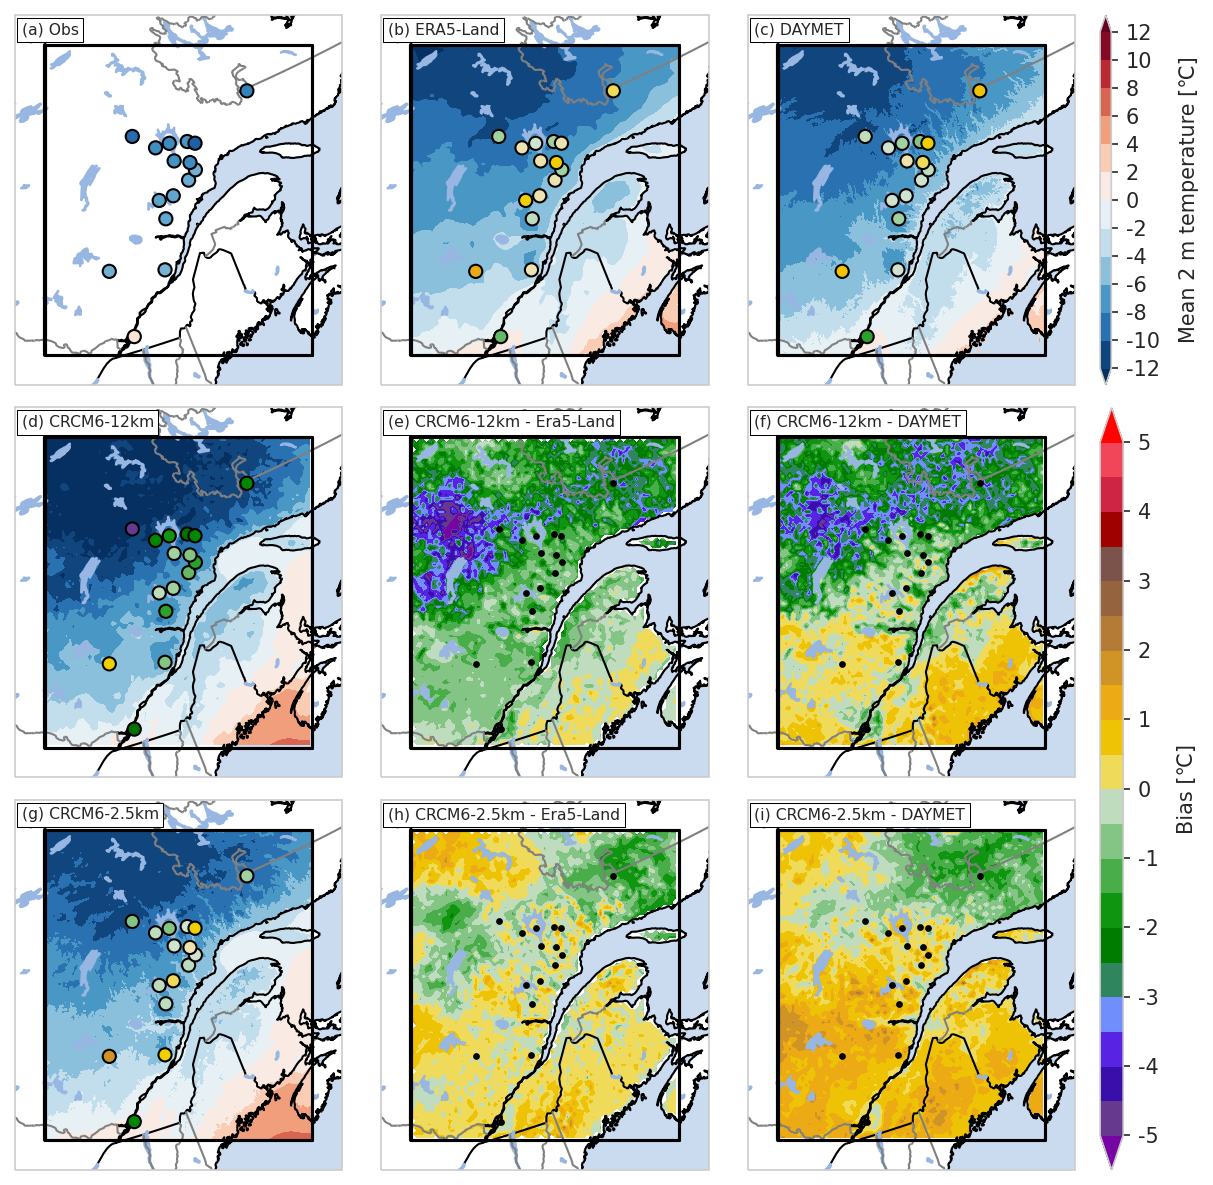

In [14]:
# dict_11km = {'lon': temp_mean_11km.lon,
#              'lat': temp_mean_11km.lat,
#              'data': temp_mean_11km,
#              'name': '12 km'}

dict_11kmp3 = {'lon': tt_11km_p3.lon,
               'lat': tt_11km_p3.lat,
               'data': tt_11km_p3.to_array()[0],
               'name': '12 km P3'}
# dict_2p5km = {'lon': temp_mean_2p5km.lon,
#               'lat': temp_mean_2p5km.lat,
#               'data': temp_mean_2p5km,
#               'name': '2.5 km'}
dict_2p5kmp3 = {'lon': tt_2p5km_p3.lon,
                'lat': tt_2p5km_p3.lat,
                'data': tt_2p5km_p3.to_array()[0],
                'name': '2.5 km P3'}
# dict_sim = {'12 km': dict_11km,
#             '12 km P3': dict_11kmp3,
#             '2.5 km': dict_2p5km,
#             '2.5 km P3': dict_2p5kmp3}
dict_sim = {'12 km P3': dict_11kmp3,
            '2.5 km P3': dict_2p5kmp3}
list_name = ['12 km P3', '2.5 km P3']



lon_era5, lat_era5 = np.meshgrid(tt_era5.longitude.values, tt_era5.latitude.values)

data_era5 = xr.DataArray(data=tt_era5.to_array()[0], dims=['time',"x", "y"],
                         coords=dict(lon=(["x", "y"], lon_era5), lat=(["x", "y"], lat_era5),time = tt_era5.time.values ))


dict_era5 = {'lon': data_era5.lon,
             'lat': data_era5.lat,
             'data': data_era5,
             'name': 'ERA5'}


tt_day = dict_daymet['tavg']

data_day = xr.DataArray(data=dict_daymet['tavg'].to_array().values[0], dims=['time',"x", "y"],
                         coords=dict(lon=(["x", "y"], tt_day.lon.values), lat=(["x", "y"],tt_day.lat.values),time = tt_day.time.values ))

data_day= data_day.reindex(time = tt_2p5km_p3.time.values+pd.Timedelta('12h')  ,fill_value = np.nan)

dict_day = {'lon': tt_day.lon.values,
            'lat': tt_day.lat.values,
            'data': data_day,
            'name': 'daymet'}

dict_ref = {'ERA5': dict_era5,
            'daymet': dict_day}

dict_rmse_tt,dict_biais_tt = plot_map_diffTT_2reffsim(dict_ref, dict_sim, list_name, dataframe_1h_obs, df_disdro, dataframe_1h_uqam,
                         dataframe_1h_momo, 'TT', begin_t, end_t)

[[-1.0948384955327164, -1.4897156968748932], [0.2795627654199411, -0.09448496632668013]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


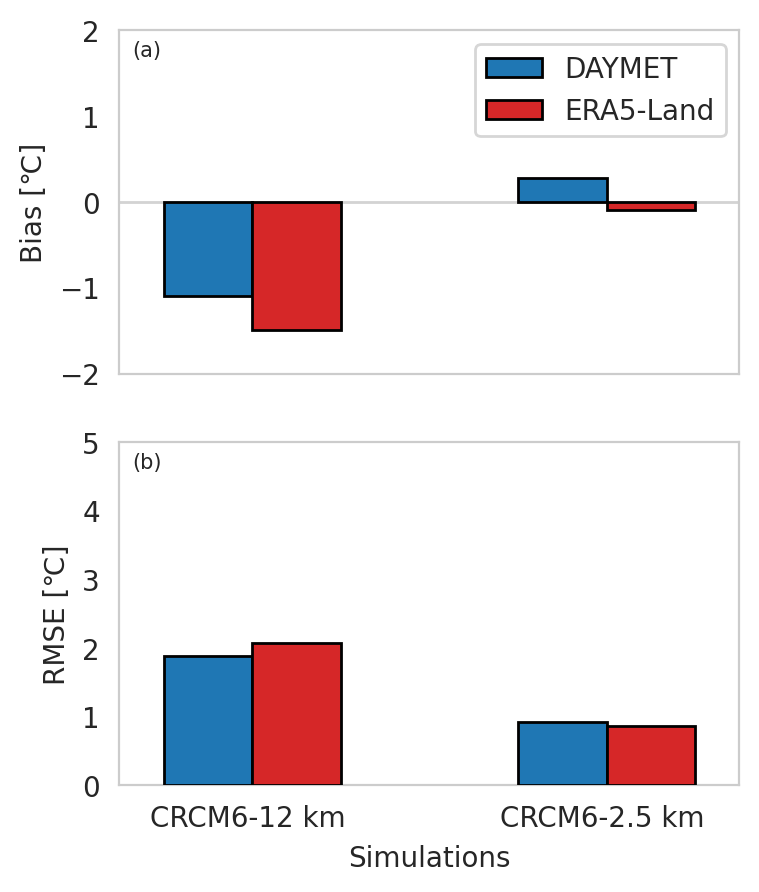

In [15]:
fig = plt.figure(facecolor='white', dpi=200, figsize=(4, 5))

spec = fig.add_gridspec(ncols=1,nrows=2)

# PR
ax = fig.add_subplot(spec[0, 0])
# ax11km = fig.add_subplot(spec[0, 0], projection=m)
ax1 = fig.add_subplot(spec[1, 0])
bbox = {'boxstyle':"square",'fc':"w"}
posi_text = (0.02, 0.97)
font = 7.5

sim = dict_biais_tt.keys()
width = 0.25
x = np.arange(len(sim))
list_biais_sim = []
list_rmse_sim = []
list_sim = []
for k in sim:

    list_biais_sim.append(dict_biais_tt[k])
    list_rmse_sim.append(dict_rmse_tt[k])
    list_sim.append('CRCM6-'+k.replace('P3',''))

print(list_biais_sim)
ax.bar(x -width*1/2, np.array(list_biais_sim)[:, 0], width=width, color='tab:blue', edgecolor='k',zorder=999,label='DAYMET')
ax.bar(x+width*1/2, np.array(list_biais_sim)[:, 1], width=width, color='tab:red', edgecolor='k',zorder=999,label='ERA5-Land')
ax.hlines(0,x[0] -width*3/2,x[-1] +width*3/2,colors='lightgrey',linewidth=1)
ax.legend(loc='upper right')
# ax.plot(np.arange(x[0] -width*3/2,x[-1] +width*3/2),np.zeros(len(np.arange(x[0] -width*3/2,x[-1] +width*3/2))),c='k')
ax.set_xlim(x[0] -width*3/2,x[-1] +width*3/2)
# ax.bar(x + width, np.array(list_rmse_sim)[:, 2], width=width, color='tab:orange', edgecolor='k')
ytext = 2.1
# ax.text(x[0]-width*1/2, ytext, 'DAYMET', rotation=45, horizontalalignment='center', fontsize=8)
# ax.text(x[0]+width*1/2, ytext, 'ERA5-Land', rotation=45, horizontalalignment='center', fontsize=8)
# ax.text(x[0]+width, ytext, 'CaPA', rotation=45, horizontalalignment='center', fontsize=8)
ax.set_ylabel('Bias [\u2103]')
# ax.set_xlabel('Simulations')
ax.tick_params(which="both",bottom=False,labelbottom=False)
# ax.set_xticks(x)
ax.set_ylim(-2,2)
#ax.set_ylim(-2.5,1.5)
ax.annotate('(a)',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)

# ax.set_xticks(x)
# ax.set_ylim(-2,2)
# ax.set_xticklabels(list_sim, rotation=0, ha='center')
ax.grid(False)

ax1.bar(x -width*1/2, np.array(list_rmse_sim)[:, 0], width=width, color='tab:blue', edgecolor='k',zorder=999)
ax1.bar(x+width*1/2, np.array(list_rmse_sim)[:, 1], width=width, color='tab:red', edgecolor='k',zorder=999)

# ax.bar(x + width, np.array(list_rmse_sim)[:, 2], width=width, color='tab:orange', edgecolor='k')
ytext = 2.1
# ax1.text(x[0]-width*1/2, ytext, 'DAYMET', rotation=45, horizontalalignment='center', fontsize=8)
# ax1.text(x[0]+width*1/2, ytext, 'ERA5-Land', rotation=45, horizontalalignment='center', fontsize=8)
# ax.text(x[0]+width, ytext, 'CaPA', rotation=45, horizontalalignment='center', fontsize=8)

# phase title
# axobs.set_title('Obs', fontsize=10)
ax1.annotate('(b)',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)
ax1.set_ylabel('RMSE [\u2103]')
ax1.set_xlabel('Simulations')
ax1.set_xticks(x)
ax1.set_ylim(0,5)
#ax1.set_ylim(0,6)
ax1.set_xticklabels(list_sim, rotation=0, ha='center')
ax1.grid(False)
ax1.set_xlim(x[0] -width*3/2,x[-1] +width*3/2)
plt.subplots_adjust(hspace=0.2)
fig.savefig(
        f'/upslope/chalifour/projet_maitrise/fig/comparaison_map_diff/diff_ref/annual_bias_all_barTT_2year.png',
        dpi=200, format='png', bbox_inches='tight', )  # Most backends support png, pdf,
fig.savefig(
    f'/upslope/chalifour/projet_maitrise/fig/comparaison_map_diff/diff_ref/annual_bias_all_barTT_2year.eps',
    dpi=200, format='eps', bbox_inches='tight', )  # Most backends support png, pdf,
plt.show()

In [16]:
# when precip mask
mask_era5 = (pr_era5 > 0.2 ).to_array()
mask_11km_p3 = (pr_11km_p3 > 0.2 ).to_array()
mask_2p5km_p3 = (pr_2p5km_p3 > 0.2 ).to_array()
mask_day = (dict_daymet['prcp']> 0.2).to_array()


#tt_era5_mask = tt_era5.to_array().where(mask_era5.values())
#tt_11km_p3_mask = tt_11km_p3.to_array().where(mask_11km_p3.values())
#tt_2p5km_p3_mask = tt_2p5km_p3.to_array().where(mask_2p5km_p3.values())

tt_era5_mask = np.ma.masked_array(data=tt_era5.to_array().values,mask=mask_era5.values, fill_value= np.nan)
tt_11km_p3_mask = np.ma.masked_array(data=tt_11km_p3.to_array().values,mask=mask_11km_p3.values, fill_value= np.nan)
tt_2p5km_p3_mask = np.ma.masked_array(data=tt_2p5km_p3.to_array().values,mask=mask_2p5km_p3.values, fill_value= np.nan)
tt_day_mask = np.ma.masked_array(data=dict_daymet['tavg'].to_array().values,mask=mask_day.values, fill_value= np.nan)

# only when precip
dataframe_1h_obs_m = dataframe_1h_obs[dataframe_1h_obs['precip_inst_pluvio'] >= 0.2]
# only when precip
dataframe_1h_uqam_m = dataframe_1h_uqam[dataframe_1h_uqam['precip_inst_pluvio'] >= 0.2]
# only when precip
dataframe_1h_momo_m = dataframe_1h_momo[dataframe_1h_momo['precip_inst_pluvio'] >= 0.2]

{}
263.0 47.5 353.0 0.0
Ploting sim 12 km P3
Ploting diff stat-sim


ValueError: operands could not be broadcast together with shapes (423,) (419,) 

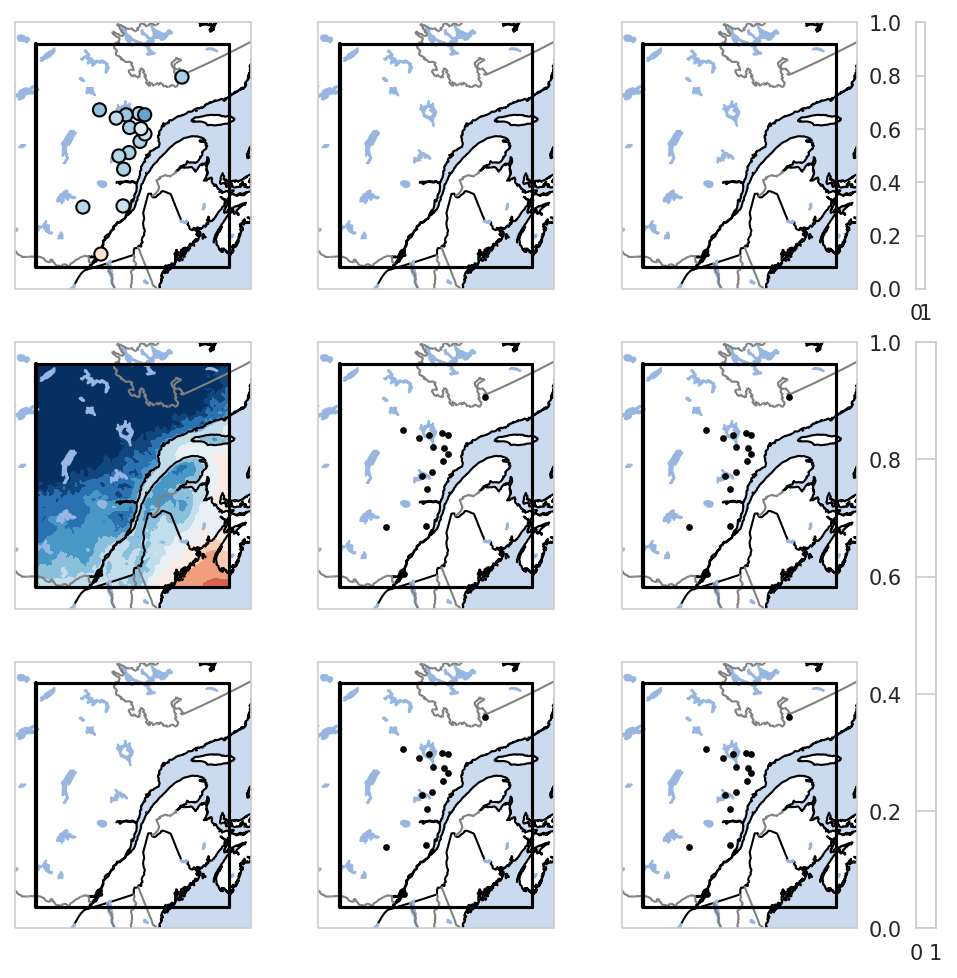

In [17]:


# dict_11km = {'lon': temp_mean_11km.lon,
#              'lat': temp_mean_11km.lat,
#              'data': temp_mean_11km,
#              'name': '12 km'}
data_11kmp3_mask = xr.DataArray(data=tt_11km_p3_mask[0], dims=['time',"x", "y"],
                         coords=dict(lon=(["x", "y"], tt_11km_p3.lon), lat=(["x", "y"], tt_11km_p3.lat),time = tt_11km_p3.time.values ))
dict_11kmp3 = {'lon': tt_11km_p3.lon,
               'lat': tt_11km_p3.lat,
               'data': data_11kmp3_mask ,
               'name': '12 km P3'}
# dict_2p5km = {'lon': temp_mean_2p5km.lon,
#               'lat': temp_mean_2p5km.lat,
#               'data': temp_mean_2p5km,
#               'name': '2.5 km'}
data_2p5kmp3_mask = xr.DataArray(data=tt_2p5km_p3_mask[0], dims=['time',"x", "y"],
                         coords=dict(lon=(["x", "y"], tt_2p5km_p3.lon), lat=(["x", "y"], tt_2p5km_p3.lat),time = tt_2p5km_p3.time.values ))

dict_2p5kmp3 = {'lon': tt_2p5km_p3.lon,
                'lat': tt_2p5km_p3.lat,
                'data': data_2p5kmp3_mask,
                'name': '2.5 km P3'}
# dict_sim = {'12 km': dict_11km,
#             '12 km P3': dict_11kmp3,
#             '2.5 km': dict_2p5km,
#             '2.5 km P3': dict_2p5kmp3}
dict_sim = {'12 km P3': dict_11kmp3,
            '2.5 km P3': dict_2p5kmp3}
list_name = ['12 km P3', '2.5 km P3']



lon_era5, lat_era5 = np.meshgrid(tt_era5.longitude.values, tt_era5.latitude.values)

data_era5 = xr.DataArray(data=tt_era5_mask[0], dims=['time',"x", "y"],
                         coords=dict(lon=(["x", "y"], lon_era5), lat=(["x", "y"], lat_era5),time = tt_era5.time.values ))


dict_era5 = {'lon': data_era5.lon,
             'lat': data_era5.lat,
             'data': data_era5,
             'name': 'ERA5'}


tt_day = dict_daymet['tavg']



data_day = xr.DataArray(data=tt_day_mask[0], dims=['time',"x", "y"],
                         coords=dict(lon=(["x", "y"], tt_day.lon.values), lat=(["x", "y"],tt_day.lat.values),time = tt_day.time.values ))


data_day = data_day.reindex(time = tt_2p5km_p3.time.values+pd.Timedelta('12h')  ,fill_value = np.nan)

dict_day = {'lon': tt_day.lon.values,
            'lat': tt_day.lat.values,
            'data': data_day,
            'name': 'daymet'}

dict_ref = {'ERA5': dict_era5,
            'daymet': dict_day}

dict_rmse_tt,dict_biais_tt = plot_map_diffTT_2reffsim(dict_ref, dict_sim, list_name, dataframe_1h_obs_m, df_disdro, dataframe_1h_uqam_m,
                         dataframe_1h_momo_m, 'TT', begin_t, end_t)

In [18]:
def get_cmap(variable):
    if variable in ['LIQUID', 'SOLID', 'FR', 'MIXFR', 'MIX', 'PR']:
        cmap = cm.get_cmap('jet', 256)
        cmap = cmap(np.linspace(0.2, 1, 256))[::10]
        cmap[0] = [162 / 256, 186 / 256, 254 / 256, 1]
        if variable in ['LIQUID', 'SOLID']:
            bounds = np.linspace(0, 2000, 22)

        elif variable in ['FR', 'MIXFR', 'MIX']:

            bounds = np.linspace(0, 150, 22)


        elif variable in ['PR']:
            bounds = np.linspace(0, 2500, 26)

        bounds[0] = 0.1
        cmap = LinearSegmentedColormap.from_list('pluvio_cmap', cmap, N=len(cmap))
        norm = BoundaryNorm(bounds, cmap.N, clip=False)

        cmap.set_over('black')
        cmap.set_under('White', alpha=1)
        return cmap, norm, bounds

    elif variable in ['TT']:
        cmap, norm, bounds =  [],[],[]
        return cmap, norm, bounds

In [19]:
# def bias_sim(array_sim,array_ref):
#     # frac_b = np.true_divide(, )
#     # frac_b=np.nan_to_num(frac_b,posinf=np.nan,neginf=np.nan)
#     biais = np.nansum((array_sim-array_ref),axis=0)/np.nansum(array_ref,axis=0)
#
#     print(np.nanmax(biais),np.nanmin(biais))
#     return biais

In [20]:
def plot_map_diffPR_2reffsim(data_sim_ref: Dict,
                  data_sim: Dict,
                  list_name_sim:List[str],
                  dataframe_1h_obs: pd.DataFrame,
                  df_disdro: pd.DataFrame,
                  dataframe_1h_uqam: pd.DataFrame,
                  dataframe_1h_momo: pd.DataFrame,
                  variable: str,
                  begin,
                  end):

    size_c = 40
    cmap, norm, bounds = get_cmap(variable)
    
    # Pie chart for each available station on the map
    image_output_dpi = 200

    nb_sim = len(data_sim.keys())
    nb_ref = len(data_sim_ref.keys())
    nb_tot_sim = nb_sim + nb_ref


    "__ Horizontal __"
    m, lonE2p5, latE2p5 = get_proj_extent()
    # plt.subplots(nb_ref+1,nb_tot_sim+1,facecolor='white', figsize=(12, 4), dpi=150,subplot_kw={'projection': ccrs.PlateCarree()})
    # ,
    fig = plt.figure(facecolor='white', figsize = (12, 8), dpi=150)
    spec = fig.add_gridspec(ncols=5,nrows=3 )

    # PR
    axobs = fig.add_subplot(spec[0, 0], projection=m)
    # ax11km = fig.add_subplot(spec[0, 0], projection=m)
    ax11kmp3 = fig.add_subplot(spec[1, 0], projection=m)
    # ax2p5km = fig.add_subplot(spec[0, 0], projection=m)
    ax2p5kmp3 = fig.add_subplot(spec[2, 0], projection=m)
    list_sim = [ax11kmp3,ax2p5kmp3]

    # # diff era5
    axera5 = fig.add_subplot(spec[0, 1], projection=m)
    # ax11km_differa5 = fig.add_subplot(spec[1, 0], projection=m)
    # ax2p5km_differa5 = fig.add_subplot(spec[1, 1], projection=m)
    ax11kmp3_differa5 = fig.add_subplot(spec[1,1], projection=m)
    ax2p5kmp3_differa5 = fig.add_subplot(spec[2, 1], projection=m)

    list_diff_era5 = [ax11kmp3_differa5, ax2p5kmp3_differa5]


    # diff capA
    axcapa = fig.add_subplot(spec[0, 2], projection=m)
    # ax11km_diffcapa = fig.add_subplot(spec[2, 0], projection=m)
    # ax2p5km_diffcapa = fig.add_subplot(spec[2, 1], projection=m)
    ax11kmp3_diffcapa = fig.add_subplot(spec[1, 2], projection=m)
    ax2p5kmp3_diffcapa = fig.add_subplot(spec[2, 2], projection=m)

    list_diff_capa = [ax11kmp3_diffcapa,ax2p5kmp3_diffcapa]

    # diff day
    axday = fig.add_subplot(spec[0, 3], projection=m)
    # ax11km_diffday = fig.add_subplot(spec[3, 0], projection=m)
    # ax2p5km_diffday = fig.add_subplot(spec[3, 1], projection=m)
    ax11kmp3_diffday = fig.add_subplot(spec[1, 3], projection=m)
    ax2p5kmp3_diffday = fig.add_subplot(spec[2, 3], projection=m)

    list_diff_day = [ ax11kmp3_diffday, ax2p5kmp3_diffday]

    caxe_1 = fig.add_subplot(spec[0,4], aspect=30, anchor='W')
    caxe_2 = fig.add_subplot(spec[1:3,4], aspect=30, anchor='W')

    list_axs = [axobs,axcapa, ax11kmp3, ax2p5kmp3,axera5,ax11kmp3_differa5,ax2p5kmp3_differa5,axday,ax11kmp3_diffcapa,ax2p5kmp3_diffcapa,ax11kmp3_diffday,ax2p5kmp3_diffday]

    xll, yll = m.transform_point(lonE2p5[0, 0], latE2p5[0, 0], ccrs.PlateCarree())
    xur, yur = m.transform_point(lonE2p5[-1, -1], latE2p5[-1, -1], ccrs.PlateCarree())

    xm, ym = m.transform_point(-73.6053330201976, 45.52028815987258, ccrs.PlateCarree())
    # list_all_obs = list_sim + [axobs,axcapa,axday,axera5]
    list_all_obs = [axobs]
    list_point_obs = list_diff_day+list_diff_era5+list_diff_capa
    
    for ax_map in list_axs:
        # Set geographic features
        ax_map.add_feature(cfeature.OCEAN.with_scale('50m'), alpha=0.5)  # couche ocean
        ax_map.add_feature(cfeature.LAND.with_scale('50m'), facecolor='none')  # couche land
        # ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac
        ax_map.add_feature(cfeature.BORDERS.with_scale('50m'))  # couche frontieres
        # ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche rivières
        coast = cfeature.NaturalEarthFeature(category='physical', scale='10m', facecolor='none',
                                             name='coastline')  # Couche côtières
        ax_map.add_feature(coast, edgecolor='black')
        ax_map.add_feature(cfeature.LAKES)
        states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                        scale='10m', facecolor='none')  # Couche provinces
        ax_map.add_feature(states_provinces, edgecolor='grey')
        ax_map.set_extent([xll + 16, xur - 8, yll + 3, yur - 0], crs=m)
        ax_map.plot([xll + 17, xll + 17], [yll + 4, yur - 1], lw=2, c='k', zorder=99999999,
                    label='Studied domain')
        ax_map.plot([xll + 17, xur - 9], [yll + 4, yll + 4], lw=1.5, c='k', zorder=99999999)
        ax_map.plot([xll + 17, xur - 9], [yur - 1, yur - 1], lw=1.5, c='k', zorder=99999999)
        ax_map.plot([xur - 9, xur - 9], [yll + 4, yur - 1], lw=1.5, c='k', zorder=99999999)

    list_lon, list_lat, list_var = get_data_stat(dataframe_1h_obs, df_disdro, dataframe_1h_uqam, dataframe_1h_momo,
                                                 begin, end, variable)


    for ax in list_all_obs:
        ax.scatter(list_lon, list_lat, c=list_var, transform=ccrs.PlateCarree(), zorder=9999, cmap=cmap,
                       norm=norm, edgecolor='k', s=size_c)

    for ax in list_point_obs:
            ax.scatter(list_lon, list_lat, c='k', transform=ccrs.PlateCarree(), zorder=9999, edgecolor='k', s=5)

    list_biais = []
    list_rmse = []
    list_diff_max =[]
    list_diff_min = []
    # cmap_diff = ctables.registry.get_colortable('Carbone42')
    cmap_diff =sns.diverging_palette(150, 275, sep=2,s=100,n=23, center='light',as_cmap=True)
    for i,sim in enumerate(list_name_sim):

        list_biais_sim = []
        list_rmse_sim = []
        list_diff_max_sim = []
        list_diff_min_sim = []
        # bounds_diff = np.arange(-5, 5.1, 0.5)
        bounds_diff = np.arange(-350, 375, 25)
        grid_out = {"lon": data_sim['12 km P3']['data'].lon.values, "lat": data_sim['12 km P3']['data'].lat.values}
        grid_in = {"lon": data_sim[sim]['lon'], "lat": data_sim[sim]['lat']}

        regridder_sim = xe.Regridder(grid_in, grid_out, "bilinear")
        data_regrid_sim = regridder_sim(data_sim[sim]['data'].values, keep_attrs=True)

        print(f'Ploting sim {sim}')

        im1 = list_sim[i].contourf(data_sim[sim]['lon'], data_sim[sim]['lat'], data_sim[sim]['data'].sum(dim='time'), 60, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, levels=bounds,
                                 extend='max')
        
        print(f'Ploting diff stat-sim')
        
        bias_obs_sim = []
        for j in range(len(list_lon)):
            pyt = (data_sim[sim]['lon']-(360+list_lon[j]))**2+(data_sim[sim]['lat']-list_lat[j])**2
            idx_lat,idx_lon = np.unravel_index(np.nanargmin(pyt), pyt.shape)
            value_day = np.nansum(data_sim[sim]['data'][:,idx_lat,idx_lon].values)
            bias_obs_sim.append(value_day-list_var[j])
        list_sim[i].scatter(list_lon, list_lat, c=bias_obs_sim, transform=ccrs.PlateCarree(), zorder=9999,cmap=cmap_diff, norm= TwoSlopeNorm(vmax=bounds_diff[-1], vcenter=0, vmin=bounds_diff[0]), edgecolor='k', s=size_c)
        
        print(f'Ploting diff Daymet - {sim}')
        # grid_out = {"lon": data_sim[sim]['lon'], "lat": data_sim[sim]['lat']}
        # output grid has a larger coverage and finer resolution
        grid_in = {"lon": data_sim_ref['daymet']['data'].lon.values, "lat": data_sim_ref['daymet']['data'].lat.values}

        regridder_day = xe.Regridder(grid_in, grid_out, "bilinear")
        # data_regrid = regridder(data_sim_ref['daymet']['data'].to_array()[0,::,::], keep_attrs=True)

        data_regrid_day = regridder_day(data_sim_ref['daymet']['data'].to_array()[0, ::, ::], keep_attrs=True)
        # data_regrid_day = np.ma.masked_invalid(data_regrid_day)

        # data_regrid_day = normalize(data_regrid_day.values)
        # data_regrid_sim_m = np.ma.masked_array(data_regrid_sim[0], data_regrid_day.mask)
        biais_sim_day = bias_sim_pr(data_regrid_sim,data_regrid_day)
        # biais_sim_day = bias_sim(data_regrid_sim,data_regrid_day)

        biais_sim_day_m = np.ma.masked_invalid(np.nanmean(data_regrid_day,axis=0))


        # bias_day = bias_sim_tot(data_regrid_sim, data_regrid_day)
        # list_biais_sim.append(bias_day)
        # rmse_day = RMSE_sim_tot(data_regrid_sim, data_regrid_day)
        # list_rmse_sim.append(rmse_day)
        
        bias_day = bias_sim_pr_tot(data_regrid_sim, data_regrid_day)
        list_biais_sim.append(bias_day)
        rmse_day = RMSE_sim_pr_tot(data_regrid_sim, data_regrid_day)
        list_rmse_sim.append(rmse_day)

        biais_im1 = list_diff_day[i].contourf(grid_out['lon'], grid_out['lat'],
                                  np.ma.masked_array(biais_sim_day,biais_sim_day_m.mask), 60,
                                  transform=ccrs.PlateCarree(),
                                  cmap=cmap_diff, levels=bounds_diff,
                                  extend='both')


        print(f'Ploting diff era5 - {sim}')

        grid_in = {"lon": data_sim_ref['ERA5']['lon'], "lat": data_sim_ref['ERA5']['lat']}
        # output grid has a larger coverage and finer resolution


        regridder_era5 = xe.Regridder(grid_in, grid_out, "bilinear")

        data_regrid_era5 = regridder_era5(data_sim_ref['ERA5']['data'].values, keep_attrs=True)
        # data_regrid_era5 = np.ma.masked_array(data_regrid_era5,data_regrid_day.mask)

        biais_sim_era5 = bias_sim_pr(data_regrid_sim,data_regrid_era5)
        # biais_sim_era5 = bias_sim(data_regrid_sim,data_regrid_era5)
        # diff = data_regrid_sim_m - data_regrid_era5
        # mask = diff == data_regrid_sim
        # arra_diff_era5 = np.ma.masked_where(mask, diff)
        # arra_era5_regrid_mask = np.ma.masked_where(mask, data_regrid_era5)
        # arra_sim_regrid_mask = np.ma.masked_where(mask, data_regrid_sim)

        # bias_era5 = bias_sim_tot(data_regrid_sim,data_regrid_era5 )
        # list_biais_sim.append(bias_era5)
        # rmse_era5 = RMSE_sim_tot( data_regrid_sim,data_regrid_era5 )
        # list_rmse_sim.append(rmse_era5)
        
        bias_era5 = bias_sim_pr_tot(data_regrid_sim,data_regrid_era5 )
        list_biais_sim.append(bias_era5)
        rmse_era5 = RMSE_sim_pr_tot( data_regrid_sim,data_regrid_era5 )
        list_rmse_sim.append(rmse_era5)
        # arra_diff_era5= np.ma.masked_greater(data_regrid_sim-data_regrid_era5,500)


        imdiff = list_diff_era5[i].contourf(grid_out['lon'], grid_out['lat'],np.ma.masked_array(biais_sim_era5,biais_sim_day_m.mask), 60,
                           transform=ccrs.PlateCarree(), cmap=cmap_diff, levels=bounds_diff,
                           extend='both')

        # list_diff_max_sim.append(np.nanmax(data_sim_ref['ERA5']['data'].values-data_regrid_sim))
        # list_diff_min_sim.append(np.nanmin(data_sim_ref['ERA5']['data'].values - data_regrid_sim))
        print(f'Ploting diff capA - {sim}')
        # grid_out = {"lon": data_sim[sim]['lon'], "lat": data_sim[sim]['lat']}
        # output grid has a larger coverage and finer resolution
        grid_in = {"lon": data_sim_ref['CaPA']['data'].lon.values, "lat": data_sim_ref['CaPA']['data'].lat.values}
        # inverse grid daymet et capa car 11km plus grande résolution

        regridder_capa = xe.Regridder(grid_in,grid_out, "bilinear")
        #
        data_regrid_capa = regridder_capa(data_sim_ref['CaPA']['data'].values , keep_attrs=True)
        biais_sim_capa = bias_sim_pr(data_regrid_sim,data_regrid_capa)
        # biais_sim_capa = bias_sim(data_regrid_sim,data_regrid_capa)
        # data_regrid_sim = np.ma.masked_array(data_regrid_sim, data_regrid_era5.mask)
        # bias_capa = bias_sim_tot(data_regrid_sim,data_regrid_capa )
        # list_biais_sim.append(bias_capa)
        # rmse_capa = RMSE_sim_tot(data_regrid_sim,data_regrid_capa )
        # list_rmse_sim.append(rmse_capa)
        
        bias_capa = bias_sim_pr_tot(data_regrid_sim,data_regrid_capa )
        list_biais_sim.append(bias_capa)
        rmse_capa = RMSE_sim_pr_tot(data_regrid_sim,data_regrid_capa )
        list_rmse_sim.append(rmse_capa)
        #

        imdiff = list_diff_capa[i].contourf(grid_out['lon'], grid_out['lat'],
                                            np.ma.masked_array(biais_sim_capa,biais_sim_day_m.mask), 60,
                                            transform=ccrs.PlateCarree(),
                                            cmap=cmap_diff, levels=bounds_diff,
                                            extend='both')
        list_biais.append(list_biais_sim)
        list_rmse.append(list_rmse_sim)



    dict_rmse = {}
    dict_biais = {}
    for i, sim in enumerate(list_name_sim):
        print()
        print(sim)
        print('Daymet,ERA5')
        print(f'rmse: {list_rmse[i]}')
        print(f'bias: {list_biais[i]}\n')
        dict_rmse[sim] = list_rmse[i]
        dict_biais[sim] = list_biais[i]

    axera5.contourf(data_sim_ref['ERA5']['lon'], data_sim_ref['ERA5']['lat'], data_sim_ref['ERA5']['data'].sum(dim='time'), 60,
                               transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, levels=bounds,
                               extend='max')
    
    bias_obs_era5 = []
    for i in range(len(list_lon)):
        pyt = (data_sim_ref['ERA5']['lon']-(360+list_lon[i]))**2+(data_sim_ref['ERA5']['lat']-list_lat[i])**2
        idx_lat,idx_lon = np.unravel_index(np.nanargmin(pyt), pyt.shape)
        value_day = np.nansum(data_sim_ref['ERA5']['data'][:,idx_lat,idx_lon].values)
        bias_obs_era5.append(value_day-list_var[i])
    axera5.scatter(list_lon, list_lat, c=bias_obs_era5, transform=ccrs.PlateCarree(), zorder=9999,cmap=cmap_diff, norm= TwoSlopeNorm(vmax=bounds_diff[-1], vcenter=0, vmin=bounds_diff[0]), edgecolor='k', s=size_c)
    
    axcapa.contourf(data_sim_ref['CaPA']['lon'], data_sim_ref['CaPA']['lat'], data_sim_ref['CaPA']['data'].sum(dim='time'), 60,
                    transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, levels=bounds,
                    extend='max')
    
    bias_obs_capa = []
    for i in range(len(list_lon)):
        pyt = (data_sim_ref['CaPA']['lon']-(360+list_lon[i]))**2+(data_sim_ref['CaPA']['lat']-list_lat[i])**2
        idx_lat,idx_lon = np.unravel_index(np.nanargmin(pyt), pyt.shape)
        value_day = np.nansum(data_sim_ref['CaPA']['data'][:,idx_lat,idx_lon].values)
        bias_obs_capa.append(value_day-list_var[i])
    axcapa.scatter(list_lon, list_lat, c=bias_obs_capa, transform=ccrs.PlateCarree(), zorder=9999,cmap=cmap_diff, norm= TwoSlopeNorm(vmax=bounds_diff[-1], vcenter=0, vmin=bounds_diff[0]), edgecolor='k', s=size_c)
    
    axday.contourf(data_sim_ref['daymet']['lon'], data_sim_ref['daymet']['lat'], data_sim_ref['daymet']['data'].to_array().sum(dim='time')[0], 60,
                    transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, levels=bounds,
                    extend='max')

    bias_obs_day = []
    for i in range(len(list_lon)):
        pyt = (360+data_sim_ref['daymet']['lon']-(360+list_lon[i]))**2+(data_sim_ref['daymet']['lat']-list_lat[i])**2
        idx_lat,idx_lon = np.unravel_index(np.nanargmin(pyt), pyt.shape)
        
        value_day = np.nansum(data_sim_ref['daymet']['data'].to_array()[0,:,idx_lat,idx_lon])
        bias_obs_day.append(value_day-list_var[i])
    axday.scatter(list_lon, list_lat, c=bias_obs_day, transform=ccrs.PlateCarree(), zorder=9999,cmap=cmap_diff, norm= TwoSlopeNorm(vmax=bounds_diff[-1], vcenter=0, vmin=bounds_diff[0]), edgecolor='k', s=size_c)
    
    # bounds_diff_tick = np.arange(-5, 5.5, 1)
    bounds_diff_tick =np.arange(-350, 400, 50)
    bounds = bounds[::5]
    
    bbox = {'boxstyle':"square",'ec':'k' ,'fc':"w",'lw':0.5}
    fig.subplots_adjust(wspace=0.005, hspace=0.005)
    posi_text = (0.02, 0.98)
    font = 7.5
    # phase title
    # axobs.set_title('Obs', fontsize=10)
    axobs.annotate('(a) Obs',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)
    # axera5.set_title('ERA5-Land', fontsize=10)
    axera5.annotate('(b) ERA5-Land',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)
    # ax11km.set_title('12 km', fontsize=14)
    # ax11kmp3.set_title('12 km', fontsize=10)
    ax11kmp3.annotate('(e) CRCM6-12km',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)
    # ax2p5km.set_title('2.5 km', fontsize=14)
    # ax2p5kmp3.set_title('2.5 km', fontsize=10)
    ax2p5kmp3.annotate('(i) CRCM6-2.5km',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)
    # axday.set_title('DAYMET', fontsize=10)
    axday.annotate('(d) DAYMET',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)
    # axcapa.set_title('CaPA', fontsize=10)
    axcapa.annotate('(c) CaPA',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)

    # phase title

    # ax11kmp3_differa5.annotate('Diff\nSim-Era5', xy=(-0.3, .5), xycoords="axes fraction", fontsize=10, ha='left')
    # ax11kmp3_diffcapa.annotate('Diff\nSim-CaPA', xy=(-0.3, .5), xycoords="axes fraction", fontsize=10, ha='left')
    # ax11kmp3_diffday.annotate('Diff\nSim-DAYMET', xy=(-0.3, .5), xycoords="axes fraction", fontsize=10, ha='left')


    ax11kmp3_differa5.annotate('(f) CRCM6-12km - Era5-Land',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)
    ax11kmp3_diffcapa.annotate('(g) CRCM6-12km - CaPA' ,xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)
    ax11kmp3_diffday.annotate('(h) CRCM6-12km - DAYMET',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)
    ax2p5kmp3_differa5.annotate('(j) CRCM6-2.5km - Era5-Land',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)
    ax2p5kmp3_diffcapa.annotate('(k) CRCM6-2.5km - CaPA' ,xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)
    ax2p5kmp3_diffday.annotate('(l) CRCM6-2.5km - DAYMET',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)


    cbar_num_format = "%d"

    colorbar_temp = fig.colorbar(im1, cax=caxe_1,
                                 format=cbar_num_format, ticks=bounds,
                                 orientation='vertical',pad=-2,shrink=0.6, aspect=30)

    colorbar_temp.set_label(f"{dict_label_color[variable]}", fontsize=10, labelpad=9)

    colorbar_temp.ax.tick_params(labelsize=10)



    colorbar_prcp = fig.colorbar(imdiff, cax=caxe_2,
                                 format=cbar_num_format, ticks=bounds_diff_tick,
                                 orientation='vertical', pad=-2,shrink=0.6, aspect=30)
    colorbar_prcp.set_label(f"Bias {dict_unit[variable]}", fontsize=10, labelpad=9)
    colorbar_prcp.ax.tick_params(labelsize=10)

    fig.tight_layout()
    fig.savefig(
        f'/upslope/chalifour/projet_maitrise/figure_final_submission/annual_bias_map_ref{variable}_2year.png',
        dpi=image_output_dpi, format='png', bbox_inches='tight', )  # Most backends support png, pdf,
    fig.savefig(
        f'/upslope/chalifour/projet_maitrise/fig/comparaison_map_diff/diff_ref/annual_bias_map_ref{variable}_2year.eps',
        dpi=image_output_dpi, format='eps', bbox_inches='tight', )  # Most backends support png, pdf,

    plt.show()
    plt.close(fig)
    return dict_rmse, dict_biais

{}
263.0 47.5 353.0 0.0
Ploting sim 12 km P3
Ploting diff stat-sim
Ploting diff Daymet - 12 km P3


/sca/compilers_and_tools/python/miniconda3/envs/base_plus/lib/python3.8/site-packages/xesmf/frontend.py:531: UserWarning: Using dimensions ('y', 'x') from data variable stack-dc87e90223c7de0e5a29dce5ab3d2023 as the horizontal dimensions for the regridding.
  warnings.warn(
/sca/compilers_and_tools/python/miniconda3/envs/base_plus/lib/python3.8/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
<ipython-input-20-4e73c1b33687>:162: RuntimeWarning: Mean of empty slice
  biais_sim_day_m = np.ma.masked_invalid(np.nanmean(data_regrid_day,axis=0))


Ploting diff era5 - 12 km P3
Ploting diff capA - 12 km P3
Ploting sim 2.5 km P3
Ploting diff stat-sim
Ploting diff Daymet - 2.5 km P3


/sca/compilers_and_tools/python/miniconda3/envs/base_plus/lib/python3.8/site-packages/xesmf/frontend.py:531: UserWarning: Using dimensions ('y', 'x') from data variable stack-dc87e90223c7de0e5a29dce5ab3d2023 as the horizontal dimensions for the regridding.
  warnings.warn(
/sca/compilers_and_tools/python/miniconda3/envs/base_plus/lib/python3.8/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
<ipython-input-20-4e73c1b33687>:162: RuntimeWarning: Mean of empty slice
  biais_sim_day_m = np.ma.masked_invalid(np.nanmean(data_regrid_day,axis=0))


Ploting diff era5 - 2.5 km P3
Ploting diff capA - 2.5 km P3

12 km P3
Daymet,ERA5
rmse: [534.1288700256431, 553.6731889040497, 138.19875716999448]
bias: [196.9719628285446, 179.70926983751062, 47.54060170618613]


2.5 km P3
Daymet,ERA5
rmse: [516.4385028437955, 526.4225187939766, 150.19402280872401]
bias: [102.54122584955616, 85.27853285852211, -46.89013527280236]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

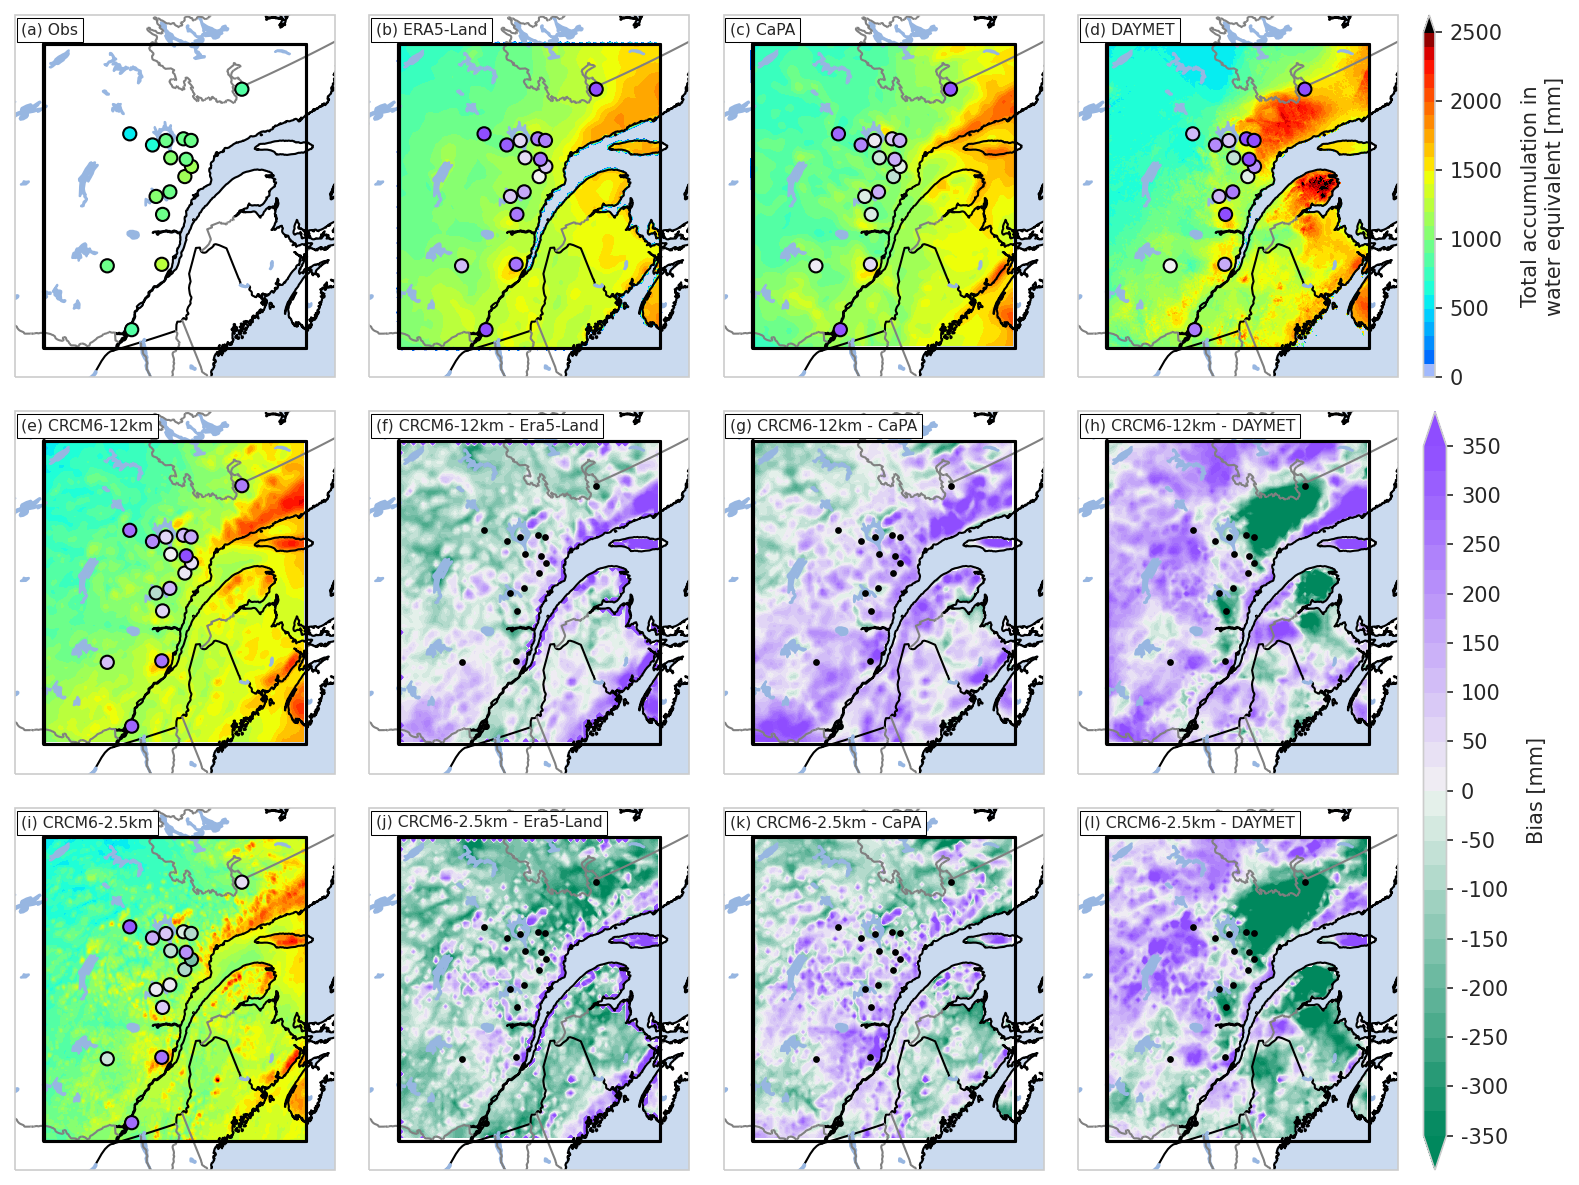

In [21]:
# Pr = False
Pr = True

if Pr:

    # dict_11km = {'lon': pr_11km.lon,
    #              'lat': pr_11km.lat,
    #              'data': pr_11km.where(mask_11km),
    #              'name': '12 km'}
    dict_11kmp3 = {'lon': pr_11km_p3.lon,
                   'lat': pr_11km_p3.lat,
                   'data': pr_11km_p3.to_array()[0],
                   'name': '12 km P3'}
    # dict_2p5km = {'lon': pr_2p5km.lon,
    #               'lat': pr_2p5km.lat,
    #               'data': pr_2p5km.where(mask_2p5km),
    #               'name': '2.5 km'}
    dict_2p5kmp3 = {'lon': pr_2p5km_p3.lon,
                    'lat': pr_2p5km_p3.lat,
                    'data': pr_2p5km_p3.to_array()[0],
                    'name': '2.5 km P3'}
    dict_sim = {'12 km P3': dict_11kmp3,
                '2.5 km P3': dict_2p5kmp3}
    list_name = [ '12 km P3', '2.5 km P3']

    # pr_era5_m = pr_era5.where(mask_era5).dropna(dim='latitude', how="all").dropna(dim='longitude', how="all")
    lon_era5, lat_era5 = np.meshgrid(pr_era5.longitude.values, pr_era5.latitude.values)
    #
    pr_tot_era5 = pr_era5['PR']

    pr_tot_era5 = pr_tot_era5.where(~(pr_tot_era5 == 0))

    data_era5 = xr.DataArray(data=pr_tot_era5, dims=['time',"x", "y"],
                             coords=dict(time =pr_tot_era5.time.values, lon=(["x", "y"], lon_era5), lat=(["x", "y"], lat_era5)))

    dict_era5 = {'lon': data_era5.lon,
                 'lat': data_era5.lat,
                 'data': data_era5,
                 'name': 'ERA5'}

    dict_capa = {'lon': data_capa.lon,
                 'lat': data_capa.lat,
                 'data': data_capa,
                 'name': 'CaPA'}

    pr_day = dict_daymet['prcp']
    pr_day = pr_day.reindex(time = pr_2p5km_p3.time.values+pd.Timedelta('12h')  ,fill_value = np.nan)

    # pr_tot_day = pr_day.sum(dim='time')
    pr_tot_day = pr_day.where(~(pr_day == 0))
    dict_day = {'lon': pr_day.lon.values,
                'lat': pr_day.lat.values,
                'data':  pr_tot_day,
                'name': 'daymet'}

    dict_ref = {'ERA5': dict_era5,
                'CaPA': dict_capa,
                'daymet': dict_day}

    dict_rmse_pr, dict_biais_pr = plot_map_diffPR_2reffsim(dict_ref, dict_sim, list_name, dataframe_1h_obs, df_disdro, dataframe_1h_uqam,dataframe_1h_momo, 'PR', begin_t, end_t)

In [ ]:
fig = plt.figure(facecolor='white', dpi=200, figsize=(4, 5))

spec = fig.add_gridspec(ncols=1,nrows=2)

# PR
ax = fig.add_subplot(spec[0, 0])
# ax11km = fig.add_subplot(spec[0, 0], projection=m)
ax1 = fig.add_subplot(spec[1, 0])
bbox = {'boxstyle':"square" ,'fc':"w"}
posi_text = (0.02, 0.97)
font = 7.5
# ax2 = ax.twinx()
# 0:obs 1:11km 2:2.5km
# 0:frac_sol 1:frac_liq 2:frac_mix
# print(np.array(list_frac)[0])
# print(np.array(list_frac)[:,0,0])
sim = dict_rmse_pr.keys()
width = 0.25
x = np.arange(len(sim))
list_biais_sim = []
list_rmse_sim = []
list_sim = []
for k in sim:
    list_biais_sim.append(dict_biais_pr[k])
    list_rmse_sim.append(dict_rmse_pr[k])
    list_sim.append('CRCM6-'+k.replace('P3',''))


ax.bar(x - width, np.array(list_biais_sim)[:, 0], width=width, color='tab:blue', edgecolor='k',zorder = 9999, label='DAYMET')
ax.bar(x, np.array(list_biais_sim)[:, 1], width=width, color='tab:red', edgecolor='k',zorder = 9999,label = 'ERA5-Land')
ax.bar(x + width, np.array(list_biais_sim)[:, 2], width=width, color='tab:orange', edgecolor='k',zorder = 9999, label = 'CaPA')
ytext = 2.7
ax.hlines(0,x[0] -width*4/2,x[-1] +width*4/2,colors='lightgrey',linewidth=1)
ax.legend(loc='upper right')
# ax.plot(np.arange(x[0] -width*3/2,x[-1] +width*3/2),np.zeros(len(np.arange(x[0] -width*3/2,x[-1] +width*3/2))),c='k')
ax.set_xlim(x[0] -width*4/2,x[-1] +width*4/2)
# ax.text(x[0]-width, ytext, 'DAYMET', rotation=45, horizontalalignment='center', fontsize=8)
# ax.text(x[0], ytext, 'ERA5-Land', rotation=45, horizontalalignment='center', fontsize=8)
# ax.text(x[0]+width, ytext, 'CaPA', rotation=45, horizontalalignment='center', fontsize=8)
ax.set_ylabel('Biais [mm]')
# ax.set_xlabel('Simulations')
ax.tick_params(which="both",bottom=True,labelbottom=False)
# ax.set_xticks(x)
ax.set_ylim(-2.5,2.5)
ax.set_xticklabels(list_sim, rotation=0, ha='center')
ax.annotate('(a)',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)
ax.legend(loc='upper right')
ax1.bar(x - width, np.array(list_rmse_sim)[:, 0], width=width, color='tab:blue', edgecolor='k',zorder = 9999)
ax1.bar(x, np.array(list_rmse_sim)[:, 1], width=width, color='tab:red', edgecolor='k',zorder = 9999)
ax1.bar(x + width, np.array(list_rmse_sim)[:, 2], width=width, color='tab:orange', edgecolor='k',zorder = 9999)
ytext = 2.7
# ax1.text(x[0]-width, ytext, 'DAYMET', rotation=45, horizontalalignment='center', fontsize=8)
# ax1.text(x[0], ytext, 'ERA5-Land', rotation=45, horizontalalignment='center', fontsize=8)
# ax1.text(x[0]+width, ytext, 'CaPA', rotation=45, horizontalalignment='center', fontsize=8)

ax1.annotate('(b)',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize=font)
ax1.set_ylabel('RMSE [mm]')
ax1.set_xlabel('Simulations')
ax1.set_xticks(x)
ax1.set_ylim(0,10)
ax1.set_xticklabels(list_sim, rotation=0, ha='center')
ax1.set_xlim(x[0] -width*4/2,x[-1] +width*4/2)
ax.grid(False)
ax1.grid(False)
plt.subplots_adjust(hspace=0.08)
fig.savefig(
        f'/upslope/chalifour/projet_maitrise/fig/comparaison_map_diff/diff_ref/annual_bias_all_barPR_2year.png',
        dpi=200, format='png', bbox_inches='tight', )  # Most backends support png, pdf,
fig.savefig(
    f'/upslope/chalifour/projet_maitrise/fig/comparaison_map_diff/diff_ref/annual_bias_all_barPR_2year.eps',
    dpi=200, format='eps', bbox_inches='tight', )  # Most backends support png, pdf,
plt.show()